# Proyecto de Visión Artificial y Reconocimiento de Patrones

## Reconocimiento Visual de Videojuegos
* Pablo
* Alberto Pérez Álvarez

## 1. Introducción



In [1]:
import os

# Configuración de entorno
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetV2B0
from transformers import TFViTModel
from transformers import TFAutoModel
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
import PIL.Image
import time
from sklearn.metrics import classification_report, confusion_matrix
import gc 

2026-01-01 19:39:33.643641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767296373.837647      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767296373.893156      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767296374.352657      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767296374.352701      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767296374.352704      55 computation_placer.cc:177] computation placer alr

In [2]:
SEED = 2026
tf.random.set_seed(SEED)
np.random.seed(SEED)

print("Versión de TensorFlow:",tf.__version__)
print("Tipo implementacion de Keras:",{tf.keras.__name__})
print(f"GPU Disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
Keras Implementation: tensorflow.keras
GPU Available: True


## 2. Carga y Gestión de Datos

In [3]:
KAGGLE_PATH = '/kaggle/input/videojuegos/images_dataset'
# Ruta que tendria en local.
LOCAL_PATH = './images_dataset' 

# Aunque las imágenes son mayores, el primer modelo (MLP) funciona mejor con 64x64
BATCH_SIZE = 64
IMG_HEIGHT = 64
IMG_WIDTH = 64
"""BATCH_SIZE = 16
IMG_HEIGHT = 480
IMG_WIDTH = 854"""

# Para saber si es Kaggle y cambiar la ruta del dataset buscamos 'KAGGLE_KERNEL_RUN_TYPE' en el entorno
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    print("Ejecución en Kaggle detectada. Ruta al dataset:",data_dir)
    data_dir = KAGGLE_PATH
else:
    data_dir = LOCAL_PATH
    print("Ejecución en un entorno local. Ruta al dataset:",data_dir)
    
data_dir = pathlib.Path(data_dir)

all_images = list(data_dir.glob('*/*.jpg'))
image_count = len(all_images)

# Para ver el tamaño de las imágenes
first_image = PIL.Image.open(all_images[0])

print("Total de imágenes del dataset cargadas:", {image_count})
print("Tamaño de las imagenes del dataset:", {first_image.size})
print("Formato de imagen:", {first_image.format})

Entorno de Kaggle
Total de imágenes encontradas: 2348
Dimensiones reales de una imagen de muestra: (640, 360)
Formato de imagen: JPEG


'BATCH_SIZE = 16\nIMG_HEIGHT = 480\nIMG_WIDTH = 854'

### 2.1 Carga de los datos y división en Train/Val/Test

Con el objetivo de garantizar la capacidad de generalización del modelo y evitar el sobreajuste, hemos dividido el conjunto de datos en tres subconjuntos: un 70% destinado al entrenamiento y optimización de parámetros; un 15% para validación, utilizado en el ajuste de hiperparámetros y control del early stopping; y un 15% restante reservado para la prueba (test), permitiendo una evaluación final imparcial.

In [4]:
def do_pipeline(data_dir, img_height, img_width, batch_size, seed=123):
    """
    Carga el dataset, lo redimensiona y lo divide en Train, Val y Test.
    Retorna: (train_ds, val_ds, test_ds, class_names)
    """
    print("Cargando el dataset...")
    
    full_ds = tf.keras.utils.image_dataset_from_directory( # menor uso de RAM al cargarlas dinámicamente
        data_dir,
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True,
        label_mode='int'
    )
    
    class_names = full_ds.class_names
    print(f"Clases encontradas ({len(class_names)}): {class_names}")
    
    total_batches = tf.data.experimental.cardinality(full_ds).numpy()
    train_size = int(0.7 * total_batches)
    val_size = int(0.15 * total_batches)
    test_size = total_batches - train_size - val_size
    
    print(f"Desglose de Batches (Total: {total_batches}):")
    print(f" ├─ Train: {train_size}")
    print(f" ├─ Val:   {val_size}")
    print(f" └─ Test:  {test_size}")
    
    # Dividimos el dataset en train val y test
    train_ds = full_ds.take(train_size) # obtiene los primeros n
    remaining = full_ds.skip(train_size) # se salta los primeros n y devuelve el resto
    
    val_ds = remaining.take(val_size)
    test_ds = remaining.skip(val_size)
    
    return train_ds, val_ds, test_ds, class_names, full_ds

train_ds, val_ds, test_ds, class_names, full_ds = do_pipeline(data_dir,IMG_HEIGHT,IMG_WIDTH,BATCH_SIZE)

--- Cargando dataset con tamaño: 64x64 y Batch: 64 ---
Found 2348 files belonging to 6 classes.


I0000 00:00:1767296398.839413      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Clases encontradas: ['GOD_OF_WAR_1', 'HADES', 'HOLLOW_KNIGHT', 'MARIO_GALAXY', 'MINECRAFT', 'UNDERTALE']
Total batches: 37 -> Train: 25, Val: 5, Test: 7


### 2.2 Calculo de pesos para contrarrestar el desbalanceo de datos

In [5]:
def calculate_class_weights(train_ds):
    """
    Extrae las etiquetas del dataset de entrenamiento y calcula los pesos
    para equilibrar las clases durante el entrenamiento.
    """
    print("Calculando pesos de las clases ")
    
    # Extraemos todas las etiquetas (y) del dataset
    # Iteramos sobre el dataset y concatenamos solo las etiquetas (y)
    train_labels = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
    
    classes = np.unique(train_labels)
    
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=train_labels
    )
    
    # Convertimos a un diccionario {indice_clase: peso} que es lo que pide Keras
    class_weight_dict = dict(zip(classes, weights))
    
    print("Pesos calculados:")
    for cls, weight in class_weight_dict.items():
        print(f"  Clase {cls}: {weight:.4f}")
        
    return class_weight_dict

class_weights = calculate_class_weights(train_ds)

Calculando pesos de las clases 
Pesos calculados:
  Clase 0: 1.0974
  Clase 1: 0.6926
  Clase 2: 1.5504
  Clase 3: 0.8493
  Clase 4: 1.1958
  Clase 5: 1.0139


### 2.3 Reducción de tiempos de espera

In [6]:
def do_performance(train_ds, val_ds, test_ds):
    AUTOTUNE = tf.data.AUTOTUNE
    
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = do_performance(train_ds, val_ds, test_ds)

### 2.4 Análisis Exploratorio (EDA)

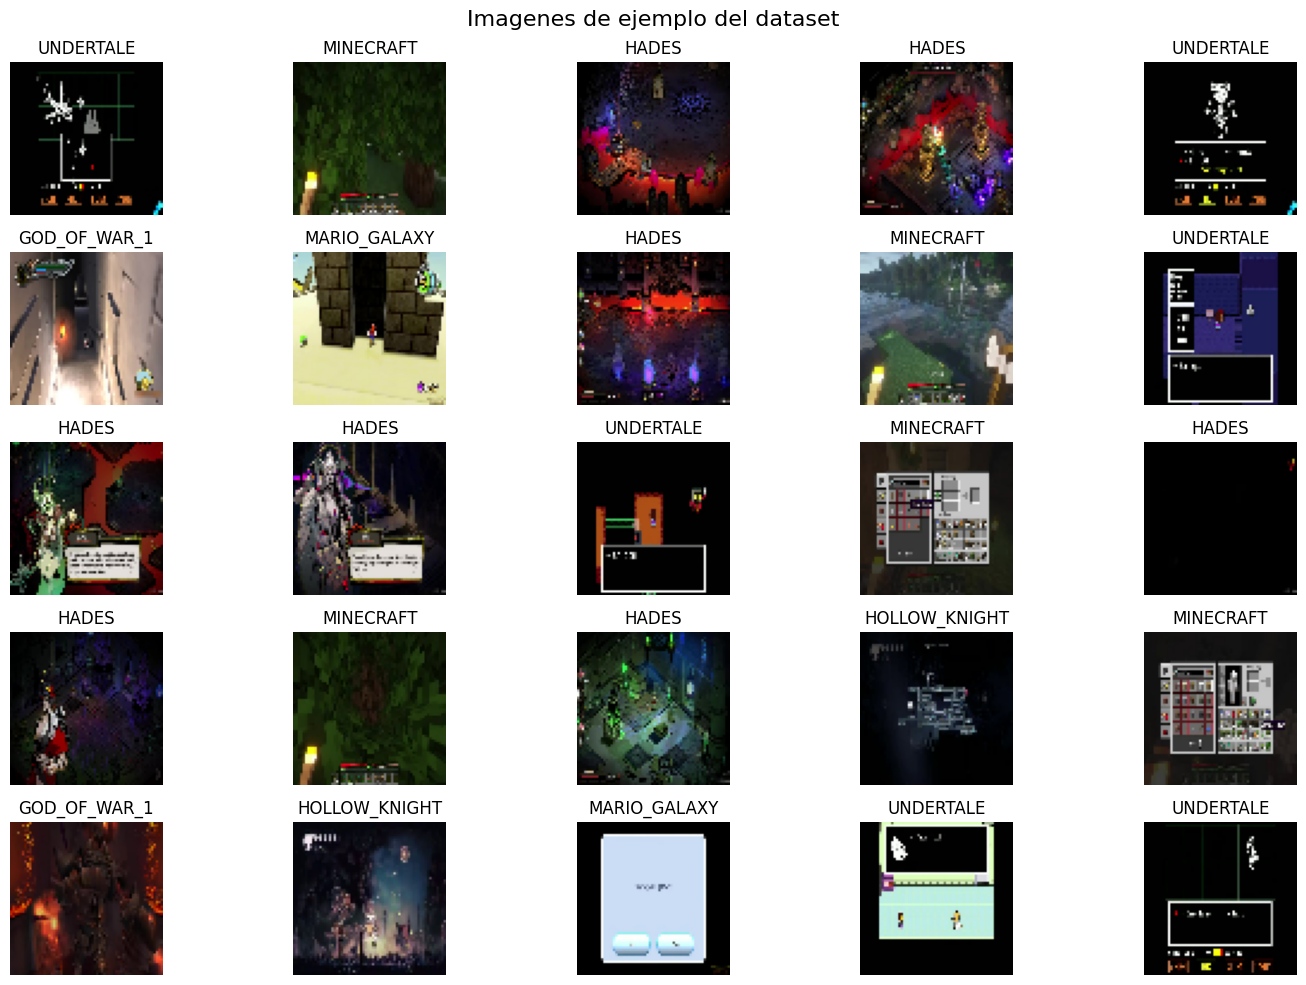

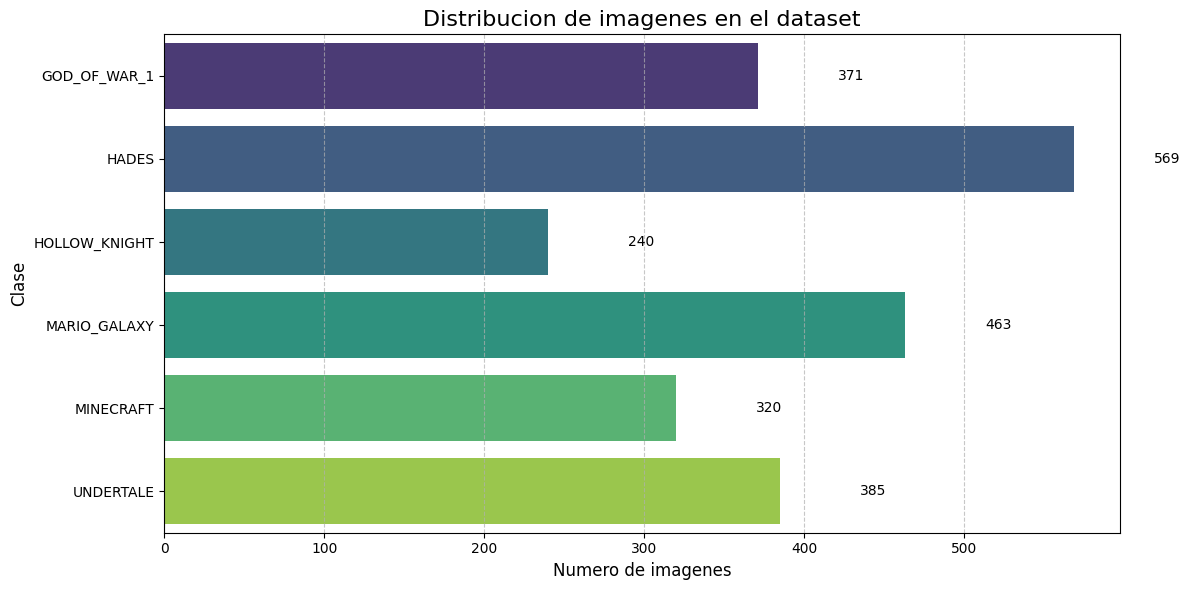

Media de imagenes: 391.33
Desviacion estandar: 114.14


In [7]:
plt.figure(figsize=(15, 10))

# 1. Usamos 'unbatch()' para sacar las imágenes de los paquetes
# 2. Usamos 'take(25)' para coger exactamente las que necesitamos
# 3. Usamos enumerate para saber en qué posición (i) del subplot estamos
for i, (image, label) in enumerate(train_ds.unbatch().take(25)):
    
    ax = plt.subplot(5, 5, i + 1)
    
    # Ya no necesitamos [i] porque 'image' es una sola foto, no un lote
    plt.imshow(image.numpy().astype("uint8"))
    
    # Manejo del label
    # Nota: Dependiendo de tu dataset, label podría ser un escalar o un array de 1 elemento
    label_index = int(label) 
    plt.title(class_names[label_index])
    plt.axis("off")

plt.suptitle("Imagenes de ejemplo del dataset", fontsize=16)
plt.tight_layout()
plt.show()


class_counts = {name: 0 for name in class_names}
for _, labels in full_ds:
    for label in labels:
        class_name = class_names[int(label)]
        class_counts[class_name] += 1

# Lo hacemos con un dataframe, pues es mas facil hacer el plot.
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(12, 6))
bplot = sns.barplot(x='Count', y='Class', data=df_counts, palette='viridis', hue='Class')
# tenemos que quitar la leyenda manualmente porque da error con legend=False
if bplot.get_legend() is not None:
    bplot.get_legend().remove()

plt.title('Distribucion de imagenes en el dataset', fontsize=16)
plt.xlabel('Numero de imagenes', fontsize=12)
plt.ylabel('Clase', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# añadimos el numero al final de la barra para verlo mejor
for index, value in enumerate(df_counts['Count']):
    plt.text(value + 50, index, str(value), va='center')

plt.tight_layout()
plt.show()

mean_count = df_counts['Count'].mean()
std_count = df_counts['Count'].std()
print(f"Media de imagenes: {mean_count:.2f}")
print(f"Desviacion estandar: {std_count:.2f}")

TODO: Conclusion

# Métricas, gráficas y pruebas

## Para cada modelo

In [8]:
# Métricas por clase y matriz de confusión

def evaluate_model_metrics(model, test_ds, class_names):
    # Generar predicciones
    y_true = []
    y_pred = []
    
    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    # Reporte de Clasificación
    print(f"\n--- Reporte de Clasificación ---\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Matriz de Confusión Normalizada
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión Normalizada')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    return np.array(y_true), np.array(y_pred)

In [9]:
# Histograma de confianza

def plot_confidence_distribution(model, test_ds):
    confidences = []
    correct_mask = []

    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        max_preds = np.max(preds, axis=1)
        pred_labels = np.argmax(preds, axis=1)
        
        confidences.extend(max_preds)
        correct_mask.extend(pred_labels == labels.numpy())

    confidences = np.array(confidences)
    correct_mask = np.array(correct_mask)

    plt.figure(figsize=(10, 6))
    sns.histplot(confidences[correct_mask], color='green', label='Correctas', kde=True, bins=20)
    sns.histplot(confidences[~correct_mask], color='red', label='Incorrectas', kde=True, bins=20)
    plt.title('Distribución de la Confianza del Modelo')
    plt.xlabel('Probabilidad de la clase predicha')
    plt.legend()
    plt.show()

In [10]:
# Latencia

def measure_latency(model, test_ds):
    # Tomar un lote de ejemplo
    for images, _ in test_ds.take(1):
        sample_img = images[0:1] # Solo una imagen
        break
    
    # Warm-up (la primera suele ser lenta por carga en GPU)
    model.predict(sample_img, verbose=0)
    
    start_time = time.time()
    for _ in range(100):
        model.predict(sample_img, verbose=0)
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / 100 * 1000 # en milisegundos
    print(f"Latencia media de inferencia: {avg_latency:.2f} ms por imagen")

In [11]:
# Mapas de calor
def get_gradcam_heatmap(model, img_array, last_conv_layer_name):
    # Crear un modelo que mapee la imagen a las activaciones de la última capa conv
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, np.argmax(preds[0])]

    # Gradiente de la clase respecto a la salida de la capa conv
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplicar cada canal por "qué tanto importa" para la clase
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalización para visualización
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

## 3. Baseline: Perceptrón Multicapa (MLP)

In [12]:
# Funcion que usamos para imprimir las graficas de los distintos modelos
def plot_history(history, model_name, stop_epoch=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    f1 = history.history['f1_score']
    val_f1 = history.history['val_f1_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc)) 
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training accuracy')
    plt.plot(epochs_range, val_acc, label='Validation accuracy')
    if stop_epoch is not None:
        plt.axvline(x=stop_epoch, color='r', linestyle='--', label=f'Early Stopping (Ep {stop_epoch+1})')
    plt.legend(loc='lower right')
    plt.title(f'{model_name}: Accuracy')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, f1, label='Training f1')
    plt.plot(epochs_range, val_f1, label='Validation f1')
    if stop_epoch is not None:
        plt.axvline(x=stop_epoch, color='r', linestyle='--', label=f'Early Stopping (Ep {stop_epoch+1})')
    plt.legend(loc='lower right')
    plt.title(f'{model_name}: F1-score')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida de training')
    plt.plot(epochs_range, val_loss, label='Perdida de validation')
    plt.legend(loc='upper right')
    plt.title(f'{model_name}: Perdida')
    plt.grid(True)
    
    plt.tight_layout() # Para que se muestren bien con márgenes

    plt.show()

In [13]:
class SparseF1Score(tf.keras.metrics.F1Score):
    def update_state(self, y_true, y_pred, sample_weight=None):
       
        num_classes = tf.shape(y_pred)[-1]  # numero de clases de la predicción
        y_true = tf.reshape(y_true, [-1])
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes) # Convertimos los enteros (sparse) a One-Hot
        
        super().update_state(y_true_one_hot, y_pred, sample_weight) # Llamamos a la función original con los datos corregidos

In [14]:
def build_mlp_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # El input es alto, ancho y n canales de RGB
        
        # Normalización de las capas (0-255 -> 0-1)
        layers.Rescaling(1./255),
        # 64 * 64 * 3 = 12,288 dimensiones, pero aplanando lo dejamos como un vector
        layers.Flatten(),
        
        # Las capas densas estaran conectadas unas entre otras
        layers.Dense(512, activation='relu'), # rectified linear unit
        layers.Dense(256, activation='relu'), 
        layers.Dense(128, activation='relu'),
        
        # Hay 10 posibles outputs
        layers.Dense(10, activation='softmax') # devuelve probabilidades para cada clase
    ], name="MLP_Baseline")
    
    return model

mlp_model_ES = build_mlp_model()
mlp_model_ES.summary()

mlp_model_ES.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]

)

callbacks_list_mlp = [
    callbacks.EarlyStopping( 
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='best_mlp.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\nMLP con Early Stopping")
start_time = time.time()

history_mlp_ES = mlp_model_ES.fit(
    train_ds,
    epochs=50, # lo ponemos alto y lo parara el early stop.
    validation_data=val_ds,
    callbacks=callbacks_list_mlp
)

end_time = time.time()
mlp_ES_training_time = end_time - start_time
print(f"\Tiempo entrenamiento MLP: {mlp_ES_training_time:.2f} s")

epoch_parada_MLP = len(history_mlp_ES.history['loss']) - 1

Model: "MLP_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 512)               6291968   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 6457482 (24.63 MB)
Trainable params: 645

<>:58: SyntaxWarning: invalid escape sequence '\T'
<>:58: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_55/2762836906.py:58: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Tiempo entrenamiento MLP: {mlp_ES_training_time:.2f} s")
I0000 00:00:1767296410.476612     128 service.cc:152] XLA service 0x7aa28436c8c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767296410.476643     128 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767296410.568516     128 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767296410.780589     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/25 [===============>..............] - ETA: 0s - loss: 2.6443 - accuracy: 0.3783 - f1_score: 0.3894 
Epoch 1: val_accuracy improved from -inf to 0.76562, saving model to best_mlp.keras
25/25 [==============================] - 5s 109ms/step - loss: 1.9140 - accuracy: 0.4950 - f1_score: 0.5033 - val_loss: 0.7968 - val_accuracy: 0.7656 - val_f1_score: 0.7676
Epoch 2/50
14/25 [===============>..............] - ETA: 0s - loss: 0.6989 - accuracy: 0.7969 - f1_score: 0.7965
Epoch 2: val_accuracy improved from 0.76562 to 0.85312, saving model to best_mlp.keras
25/25 [==============================] - 0s 19ms/step - loss: 0.6244 - accuracy: 0.8081 - f1_score: 0.8072 - val_loss: 0.4715 - val_accuracy: 0.8531 - val_f1_score: 0.8542
Epoch 3/50
14/25 [===============>..............] - ETA: 0s - loss: 0.4181 - accuracy: 0.8661 - f1_score: 0.8647
Epoch 3: val_accuracy improved from 0.85312 to 0.85938, saving model to best_mlp.keras
25/25 [==============================] - 0s 19ms/step - loss: 0.4401

#### Sin Early Stopping para comparar entre modelos
Originalmente únicamente lo ejecutábamos con Early Stopping, pero con el fin de visualizar mejor las gráficas y una mejor comparación con otros modelos (a igualdad de épocas), hemos decidido volver a entrenarlo sin Early Stopping.

In [15]:
mlp_model = build_mlp_model()
#mlp_model.summary()

mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]

)

callbacks_list_mlp_no_ES = [
    callbacks.ModelCheckpoint(
        filepath='best_mlp.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\nMLP")
start_time = time.time()

history_mlp = mlp_model.fit(
    train_ds,
    epochs=50, 
    validation_data=val_ds,
    callbacks=callbacks_list_mlp_no_ES
)

end_time = time.time()
mlp_training_time = end_time - start_time
print(f"\Tiempo entrenamiento MLP: {mlp_training_time:.2f} s")


MLP
Epoch 1/50


<>:32: SyntaxWarning: invalid escape sequence '\T'
<>:32: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_55/120428246.py:32: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Tiempo entrenamiento MLP: {mlp_training_time:.2f} s")


13/25 [==============>...............] - ETA: 0s - loss: 2.3719 - accuracy: 0.4363 - f1_score: 0.4514 
Epoch 1: val_accuracy improved from -inf to 0.83125, saving model to best_mlp.keras
25/25 [==============================] - 2s 26ms/step - loss: 1.6823 - accuracy: 0.5606 - f1_score: 0.5721 - val_loss: 0.6480 - val_accuracy: 0.8313 - val_f1_score: 0.8197
Epoch 2/50
14/25 [===============>..............] - ETA: 0s - loss: 0.5189 - accuracy: 0.8449 - f1_score: 0.8436
Epoch 2: val_accuracy did not improve from 0.83125
25/25 [==============================] - 0s 5ms/step - loss: 0.5185 - accuracy: 0.8419 - f1_score: 0.8410 - val_loss: 0.4877 - val_accuracy: 0.8313 - val_f1_score: 0.8336
Epoch 3/50
14/25 [===============>..............] - ETA: 0s - loss: 0.3493 - accuracy: 0.8984 - f1_score: 0.8981
Epoch 3: val_accuracy improved from 0.83125 to 0.88437, saving model to best_mlp.keras
25/25 [==============================] - 0s 18ms/step - loss: 0.3171 - accuracy: 0.8975 - f1_score: 0.8975

#### Gráficas de accuracy y perdida

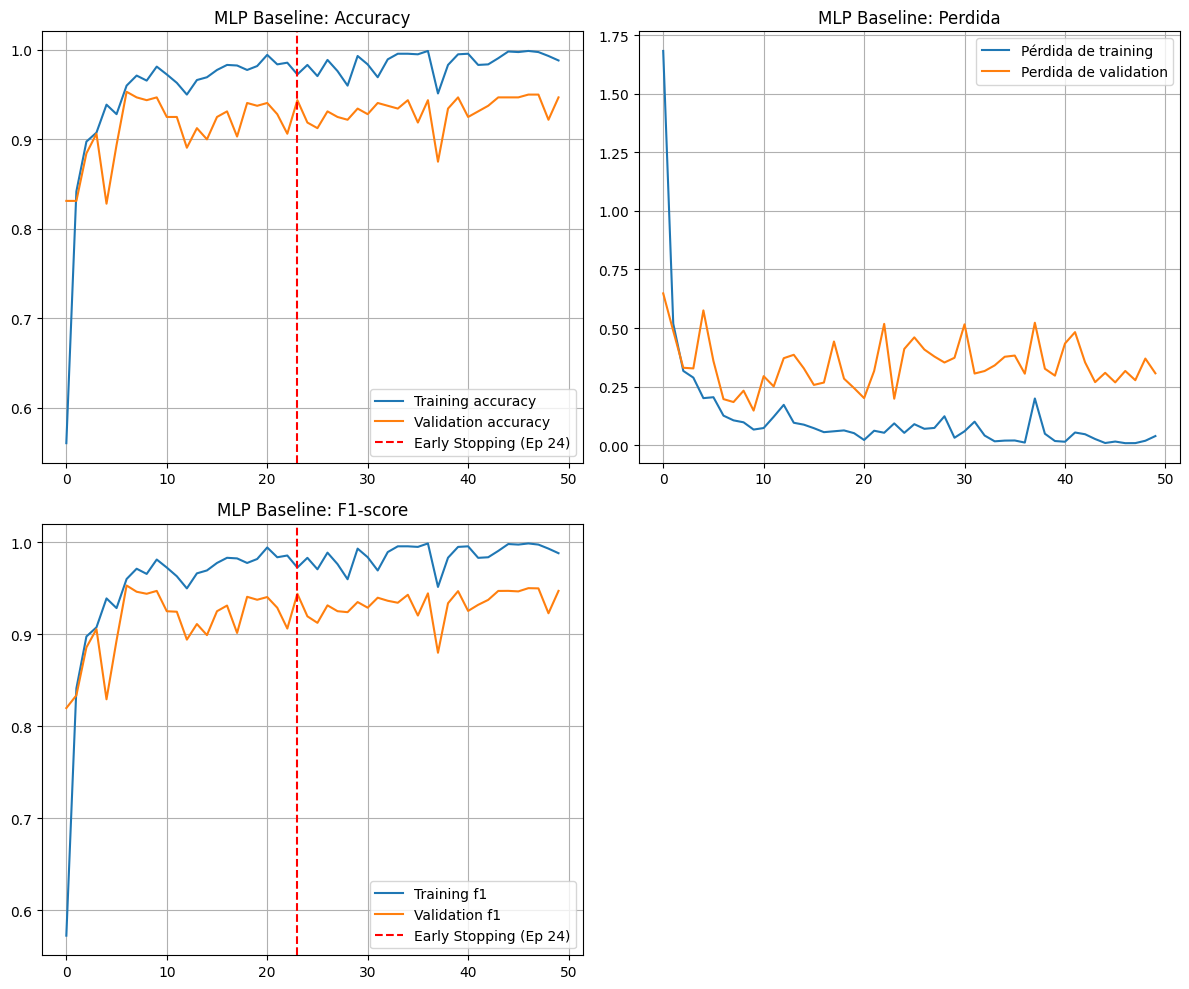

In [16]:
plot_history(history_mlp, "MLP Baseline", epoch_parada_MLP)

#### Tabla comparativa

In [17]:
mlp_val_acc = max(history_mlp.history['val_accuracy'])
mlp_val_f1 = max(history_mlp.history['val_f1_score'])
mlp_time = mlp_training_time

mlpES_val_acc = max(history_mlp_ES.history['val_accuracy'])
mlpES_val_f1 = max(history_mlp_ES.history['val_f1_score'])
mlpES_time = mlp_ES_training_time

print("\n" + "="*50)
print("      COMPARATIVA: MLP con vs sin Early Stopping")
print("="*40)
print(f"{'Métrica':<20} | {'MLP':<15} | {'MLP con ES':<15}")
print("-" * 56)
print(f"{'Tiempo (s)':<20} | {mlp_time:.1f}            | {mlpES_time:.1f}")
print(f"{'Mejor Accuracy':<20} | {mlp_val_acc:.4f}          | {mlpES_val_acc:.4f}")
print(f"{'Mejor F1-Score':<20} | {mlp_val_f1:.4f}          | {mlpES_val_f1:.4f}")


      COMPARATIVA: MLP con vs sin Early Stopping
Métrica              | MLP             | MLP con ES     
--------------------------------------------------------
Tiempo (s)           | 10.1            | 9.9
Mejor Accuracy       | 0.9531          | 0.9500
Mejor F1-Score       | 0.9530          | 0.9500


#### Evaluación
TODO: Conclusion

## 4. Arquitectura Propia: Red Neuronal Convolucional (CNN)

In [18]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_ds, val_ds, test_ds, class_names, full_ds = do_pipeline(data_dir,IMG_HEIGHT,IMG_WIDTH,BATCH_SIZE)
train_ds, val_ds, test_ds = do_performance(train_ds, val_ds, test_ds)

--- Cargando dataset con tamaño: 224x224 y Batch: 64 ---
Found 2348 files belonging to 6 classes.
Clases encontradas: ['GOD_OF_WAR_1', 'HADES', 'HOLLOW_KNIGHT', 'MARIO_GALAXY', 'MINECRAFT', 'UNDERTALE']
Total batches: 37 -> Train: 25, Val: 5, Test: 7


In [19]:
def build_cnn_model():
    # evitamos memorizar el dataset con data augmentation 
    # Giramos y hacemos zoom aleatorio a las imagenes mientras entrena
    data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
    ], name="data_augmentation")
    
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # 224x224 pixeles, 3 canales RGB
    
    x = data_augmentation(inputs)

    # 0-255 a 0-1.
    x = layers.Rescaling(1./255)(x)

    # Convoluciones
    
    # Buscamos detalles simples como bordes o esquinas.
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x) # Esto ayuda a estabilizar el aprendizaje
    x = layers.MaxPooling2D((2, 2))(x) # Reducimos la imagen a la mitad, 32x32

    # Buscamos texturas o formas más definidas.
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 16x16

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 8x8

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 4x4

    # Los datos a un vector 
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    
    # Hacemos dropout para apagar la mitad de las neuronas al azar y evitar overfitting
    x = layers.Dropout(0.5)(x) 
    
    # 10 outputs
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Custom_CNN")
    return model

cnn_model_ES = build_cnn_model()
cnn_model_ES.summary()

cnn_model_ES.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_list_cnn = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10, 
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='best_cnn.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0 
    )
]

print("\nCNN")
start_time_cnn = time.time()

history_cnn_ES = cnn_model_ES.fit(
    train_ds,
    epochs=50, # no deberia llegar a hacer los 50 por el early stop
    validation_data=val_ds,
    callbacks=callbacks_list_cnn,
    verbose=1
)

end_time_cnn = time.time()
cnn_ES_training_time = end_time_cnn - start_time_cnn
print(f"\nTiempo de entrenamiento CNN: {cnn_ES_training_time:.2f} s")
epoch_parada_CNN = len(history_cnn_ES.history['loss']) - 1

Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0

#### Sin Early Stopping

In [20]:
callbacks_list_cnn_no_ES = [
    callbacks.ModelCheckpoint(
        filepath='best_cnn.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0 
    )
]

cnn_model = build_cnn_model()
cnn_model.summary()

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

print("\nCNN sin Early Stopping")
start_time_cnn = time.time()

history_cnn = cnn_model.fit(
    train_ds,
    epochs=50, 
    validation_data=val_ds,
    callbacks=callbacks_list_cnn_no_ES,
    verbose=1
)

end_time_cnn = time.time()
cnn_training_time = end_time_cnn - start_time_cnn
print(f"\nTiempo de entrenamiento CNN sin Early Stop: {cnn_training_time:.2f} s")


Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0

In [21]:
# COMPARACION DE EFICIENCIA ENTRE CNN Y MLP
# Intentamos recuperar los datos del MLP anterior para comparar.
# Si no existen (por no haber corrido esa celda), ponemos ceros para que no falle el código.
try:
    mlp_val_acc = max(history_mlp.history['val_accuracy'])
    mlp_val_f1 = max(history_mlp.history['val_f1_score'])
    mlp_time = mlp_model.count_params()
except NameError:
    mlp_val_acc = 0.0 
    mlp_val_f1 = 0.0
    mlp_time = 0    

cnn_val_acc = max(history_cnn.history['val_accuracy'])
cnn_val_f1 = max(history_cnn.history['val_f1_score'])
cnn_params = cnn_model.count_params()

print("\n" + "="*40)
print("      COMPARATIVA: MLP vs CNN")
print("="*40)
print(f"{'Métrica':<20} | {'MLP':<15} | {'CNN Propia':<15}")
print("-" * 56)
print(f"{'Nº Parámetros':<20} | {mlp_time:<15,} | {cnn_params:<15,}")
print(f"{'Mejor Accuracy':<20} | {mlp_val_acc:.4f}          | {cnn_val_acc:.4f}")
print(f"{'Mejor F1-Score':<20} | {mlp_val_f1:.4f}          | {cnn_val_f1:.4f}")


if cnn_params > 0 and mlp_time > 0:
    ratio_mlp = mlp_time / mlp_val_acc
    ratio_cnn = cnn_params / cnn_val_acc
    print("-" * 56)
    print(f"{'Eficiencia':<20} | {int(ratio_mlp):<15,} | {int(ratio_cnn):<15,} (menos mejor)")


      COMPARATIVA: MLP vs CNN
Métrica              | MLP             | CNN Propia     
--------------------------------------------------------
Nº Parámetros        | 6,457,482       | 26,086,090     
Mejor Accuracy       | 0.9531          | 0.9594
Mejor F1-Score       | 0.9530          | 0.9591
--------------------------------------------------------
Eficiencia           | 6,775,063       | 27,190,712      (menos mejor)


#### Comparación entre CNN y MLP

TODO: Conclusion

#### Gráficas de accuracy y perdida

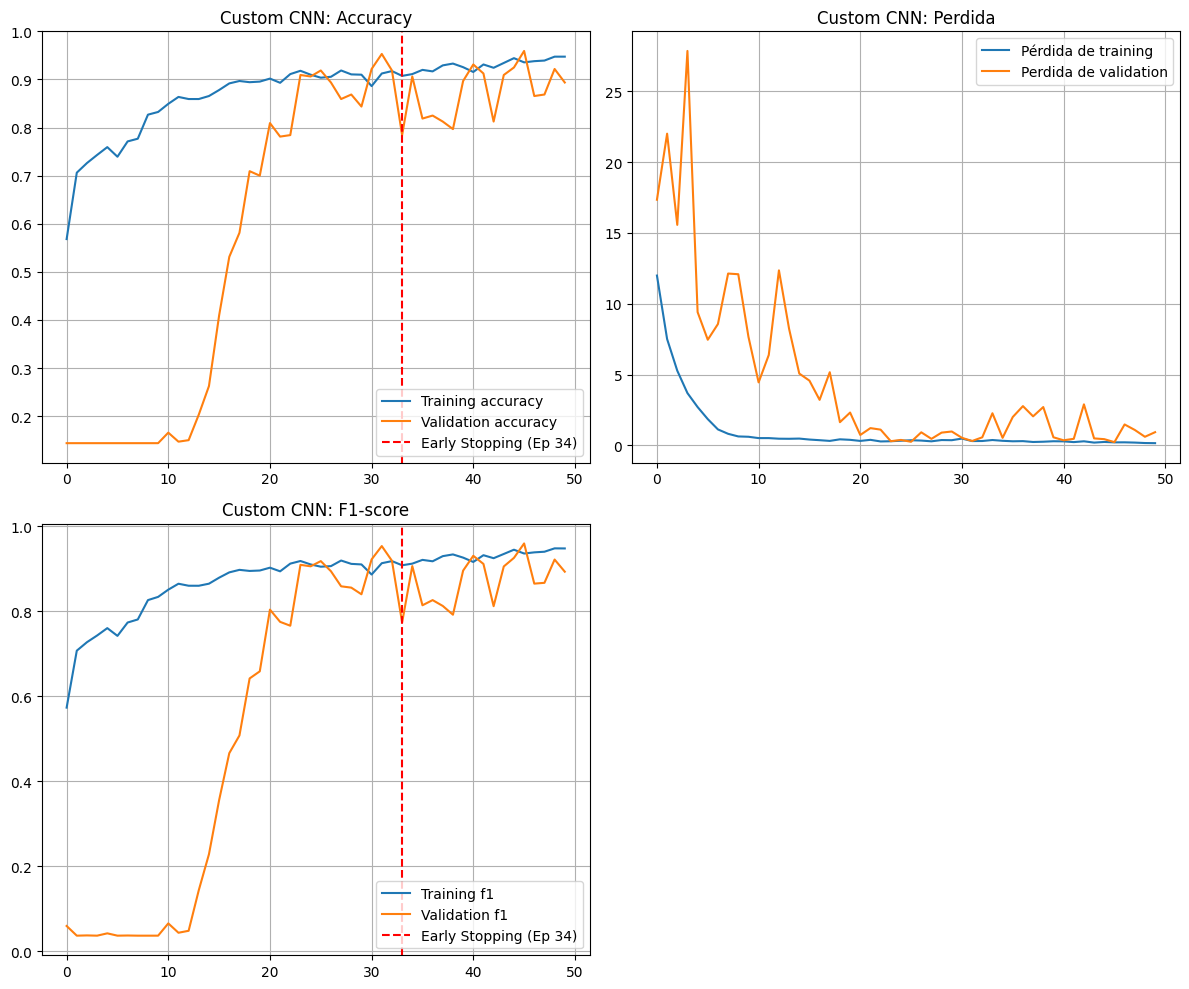

In [22]:
plot_history(history_cnn, "Custom CNN", epoch_parada_CNN)

#### Evaluación
TODO: Conclusion

### Estudio de Data Augmentation, Normalizacion y Dropout

#### Sin Data Augmentation

In [23]:
def build_cnn_model_without_DA():
    # evitamos memorizar el dataset con data augmentation 
    # Giramos y hacemos zoom aleatorio a las imagenes mientras entrena
    
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # 64x64 pixeles, 3 canales RGB
    
    x = inputs

    # 0-255 a 0-1.
    x = layers.Rescaling(1./255)(x)

    # Convoluciones
    
    # Buscamos detalles simples como bordes o esquinas.
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x) # Esto ayuda a estabilizar el aprendizaje
    x = layers.MaxPooling2D((2, 2))(x) # Reducimos la imagen a la mitad, 32x32

    # Buscamos texturas o formas más definidas.
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 16x16

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 8x8

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 4x4

    # Los datos a un vector 
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    
    # Hacemos dropout para apagar la mitad de las neuronas al azar y evitar overfitting
    x = layers.Dropout(0.5)(x) 
    
    # 10 outputs
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Custom_CNN")
    return model

cnn_model = build_cnn_model_without_DA()
cnn_model.summary()

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_list_cnn = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
]

print("\nCNN sin DA")
start_time_cnn_w_DA = time.time()

history_cnn_without_DA = cnn_model.fit(
    train_ds,
    epochs=50, # no deberia llegar a hacer los 50 por el early stop
    validation_data=val_ds,
    callbacks=callbacks_list_cnn,
    verbose=1
)

end_time_cnn = time.time()
cnn_training_time_w_DA = end_time_cnn - start_time_cnn_w_DA
print(f"\nTiempo de entrenamiento CNN: {cnn_training_time_w_DA:.2f} s")

Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      1

#### Sin Normalizacion

In [24]:
def build_cnn_model_without_N():
    # evitamos memorizar el dataset con data augmentation 
    # Giramos y hacemos zoom aleatorio a las imagenes mientras entrena
    data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
    ], name="data_augmentation")
    
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # 64x64 pixeles, 3 canales RGB
    
    x = data_augmentation(inputs)

    # 0-255 a 0-1.
    x = layers.Rescaling(1./255)(x)

    # Convoluciones
    
    # Buscamos detalles simples como bordes o esquinas.
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x) # Esto ayuda a estabilizar el aprendizaje
    x = layers.MaxPooling2D((2, 2))(x) # Reducimos la imagen a la mitad, 32x32

    # Buscamos texturas o formas más definidas.
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 16x16

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 8x8

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 4x4

    # Los datos a un vector 
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    
    # Hacemos dropout para apagar la mitad de las neuronas al azar y evitar overfitting
    x = layers.Dropout(0.5)(x) 
    
    # 10 outputs
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Custom_CNN")
    return model

cnn_model = build_cnn_model_without_N()
cnn_model.summary()

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_list_cnn = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
]

print("\nCNN")
start_time_cnn = time.time()

history_cnn_without_normalization = cnn_model.fit(
    train_ds,
    epochs=50, # no deberia llegar a hacer los 50 por el early stop
    validation_data=val_ds,
    callbacks=callbacks_list_cnn,
    verbose=1
)

end_time_cnn = time.time()
cnn_training_time = end_time_cnn - start_time_cnn
print(f"\nTiempo de entrenamiento CNN: {cnn_training_time:.2f} s")

Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 32)      0

#### Sin dropout

In [25]:
def build_cnn_model_without_dropout():
    # evitamos memorizar el dataset con data augmentation 
    # Giramos y hacemos zoom aleatorio a las imagenes mientras entrena
    data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
    ], name="data_augmentation")
    
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # 64x64 pixeles, 3 canales RGB
    
    x = data_augmentation(inputs)

    # 0-255 a 0-1.
    x = layers.Rescaling(1./255)(x)

    # Convoluciones
    
    # Buscamos detalles simples como bordes o esquinas.
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x) # Esto ayuda a estabilizar el aprendizaje
    x = layers.MaxPooling2D((2, 2))(x) # Reducimos la imagen a la mitad, 32x32

    # Buscamos texturas o formas más definidas.
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 16x16

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 8x8

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 4x4

    # Los datos a un vector 
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)    
    
    # 10 outputs
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Custom_CNN")
    return model

cnn_model = build_cnn_model_without_dropout()
cnn_model.summary()

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_list_cnn = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
]

print("\nCNN")
start_time_cnn = time.time()

history_cnn_without_dropout = cnn_model.fit(
    train_ds,
    epochs=50, # no deberia llegar a hacer los 50 por el early stop
    validation_data=val_ds,
    callbacks=callbacks_list_cnn,
    verbose=1
)

end_time_cnn = time.time()
cnn_training_time = end_time_cnn - start_time_cnn
print(f"\nTiempo de entrenamiento CNN: {cnn_training_time:.2f} s")

Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_13 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 112, 112, 32)      0

#### Gráficas

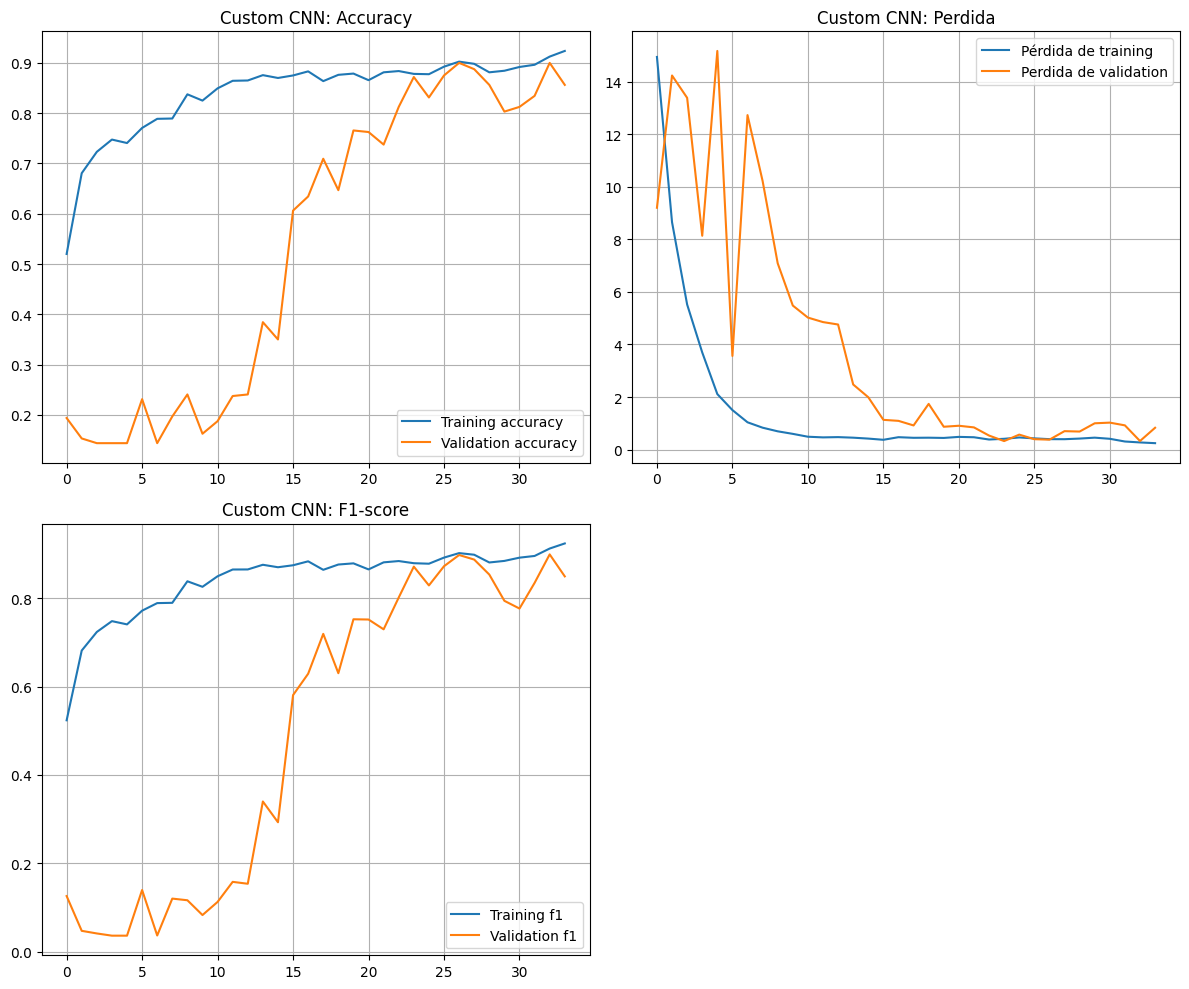

In [26]:
#Original para comparar
plot_history(history_cnn_ES, "Custom CNN")

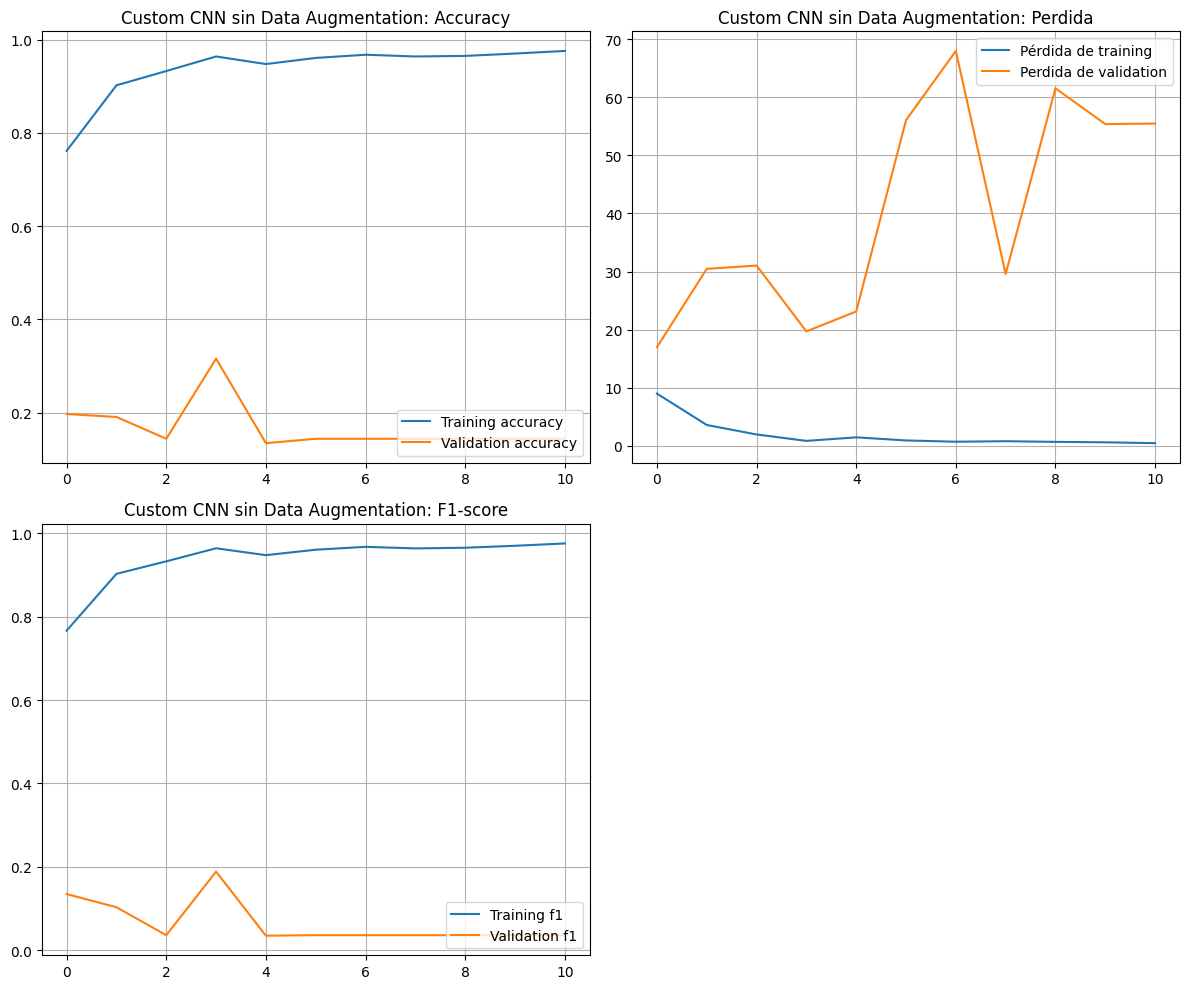

In [27]:
plot_history(history_cnn_without_DA, "Custom CNN sin Data Augmentation")


Vemos que al eliminar el data augmentation (y por tanto las rotaciones y los zooms aleatorios), la red se aprende de memoria las características en vez de generalizar, lo que lleva a un mayor puntuaje en training y menor en validation (overfitting). Además podemos ver que los picos han aumentado, posiblemente a causa del gran overfitting que tiene el modelo sin aplicar un data augmentation.

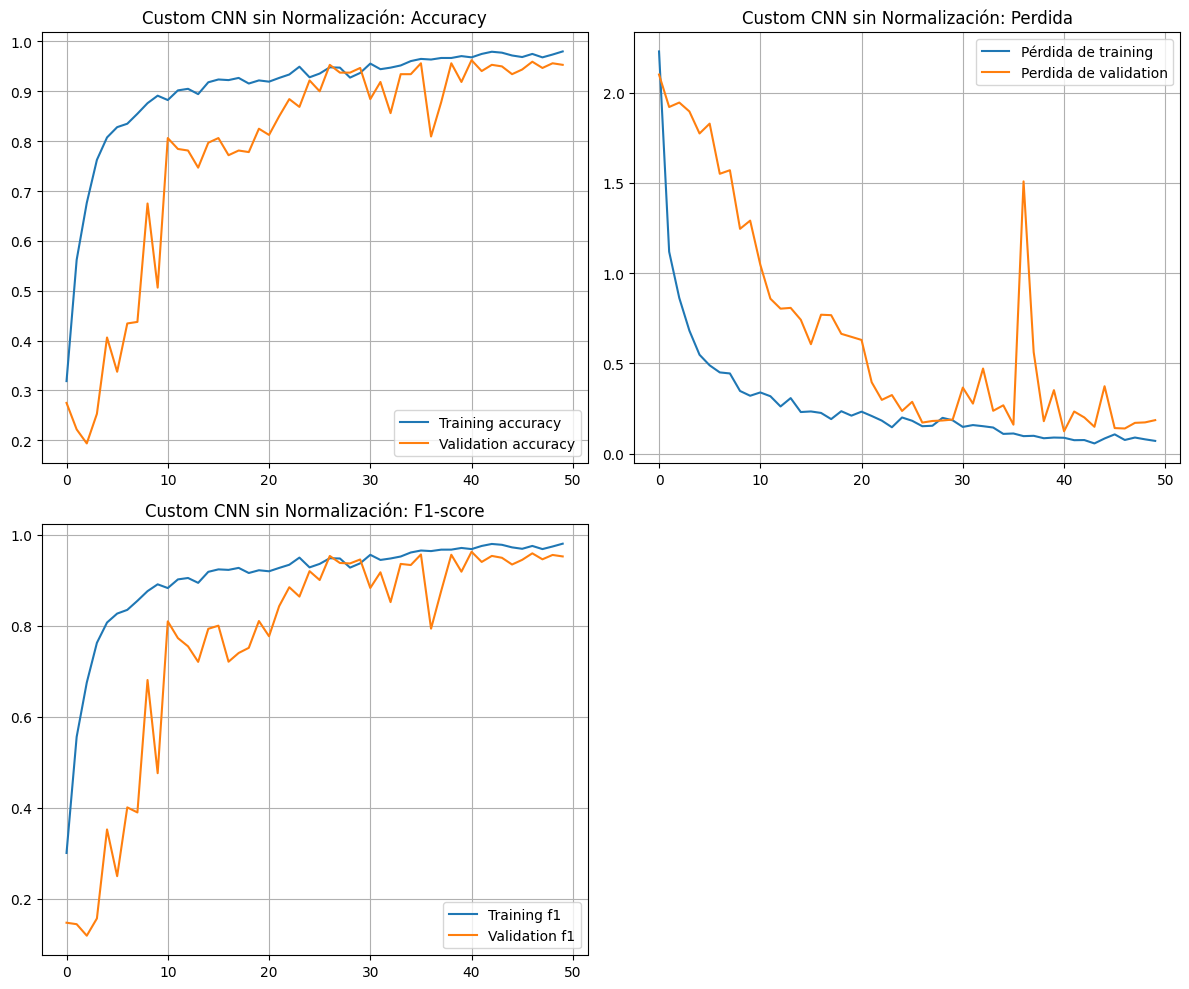

In [28]:
plot_history(history_cnn_without_normalization, "Custom CNN sin Normalización")

Vemos que sin aplicar Batch Normalization el modelo se vuelve muy inestable en sus predicciones de validation. Esto puede deberse a que los pesos de la red cambian demasiado bruscamente, haciendo que el gradiente sea inestable. En adición, el modelo tarda más en aprender, posiblemente por estos cambios tan bruscos de parámetros.

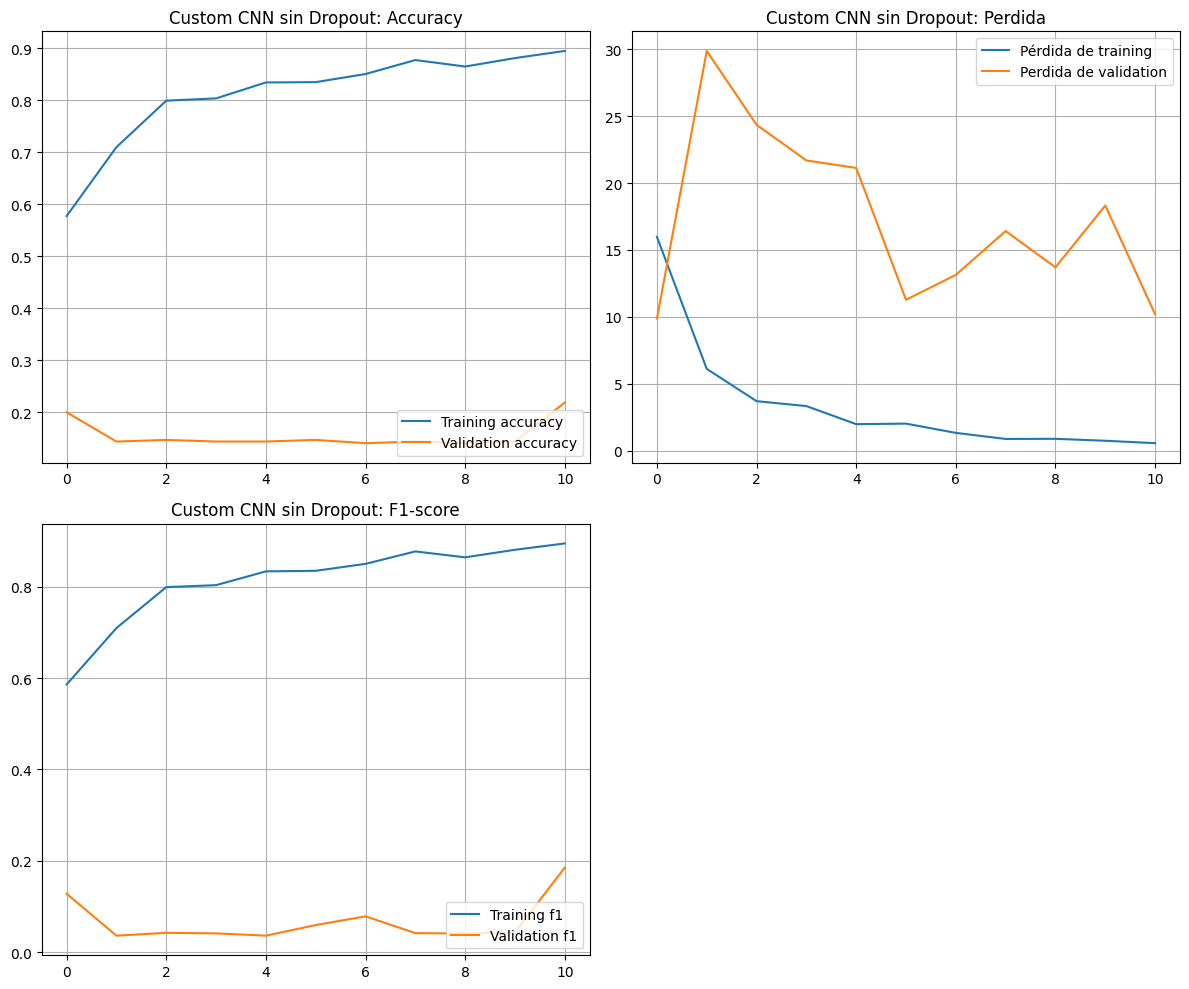

In [29]:
plot_history(history_cnn_without_dropout, "Custom CNN sin Dropout")

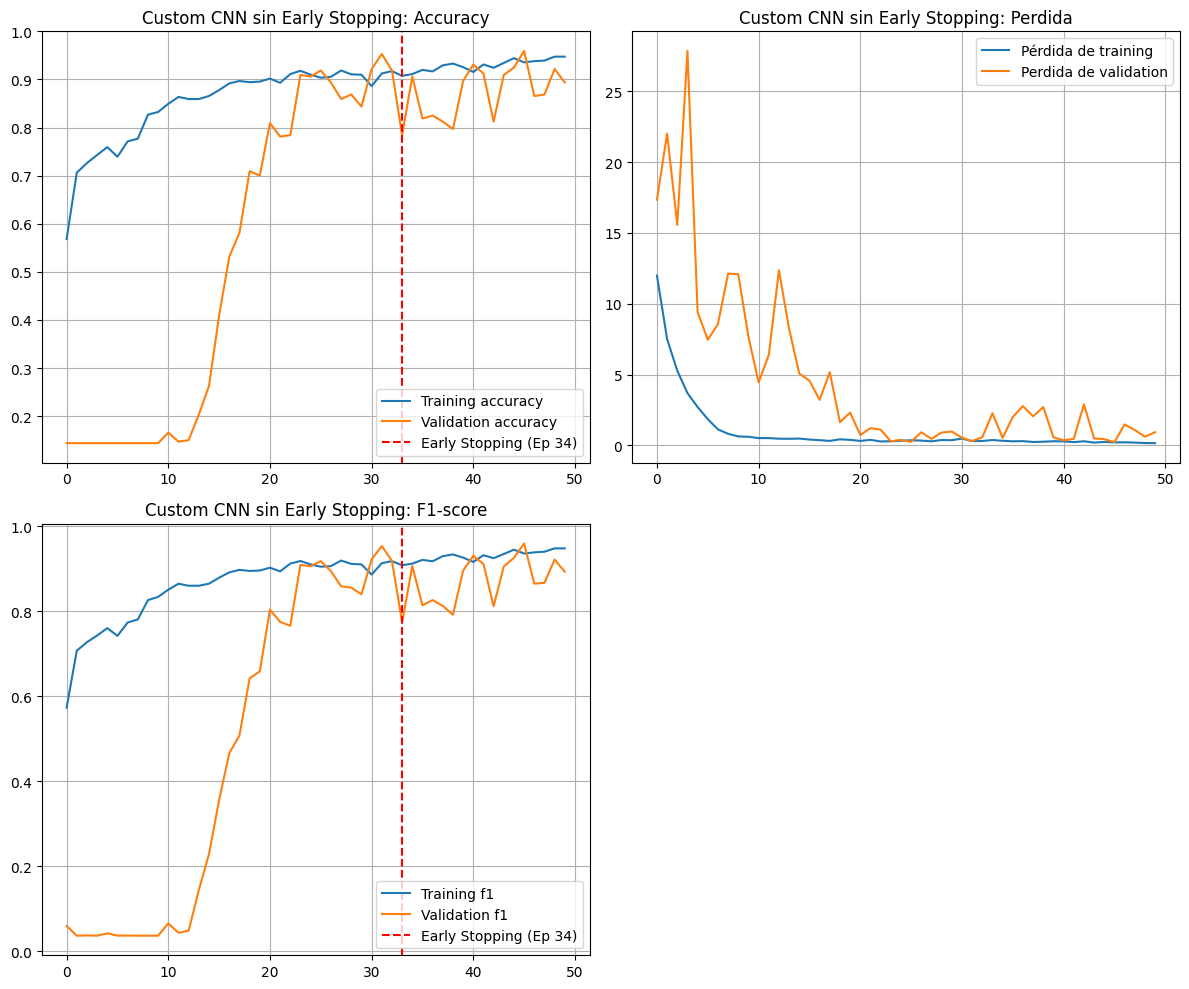

In [30]:
plot_history(history_cnn, "Custom CNN sin Early Stopping", epoch_parada_CNN)

TODO: Conclusion

## 5. Transfer Learning (Estado del Arte)

#### Función genérica para agregar más modelos

In [31]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

def build_generic_model(model_name, img_height, img_width, num_classes=10):
    inputs = keras.Input(shape=(img_height, img_width, 3))
    
    x = data_augmentation(inputs)
    
    # Selección del modelo base y Preprocesamiento específico
    if model_name == 'EfficientNetV2B0':
        # EfficientNetV2 normaliza internamente. Espera [0, 255]
        base_model = tf.keras.applications.EfficientNetV2B0(
            include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3)
        )
    
    elif model_name == 'ConvNeXtTiny':
        base_model = tf.keras.applications.ConvNeXtTiny(
            include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3)
        )
        
    elif model_name == 'ResNet50V2':
        # como ResNetV2 espera inputs entre [-1, 1] necesitamos reescalar.
        x = layers.Rescaling(1./127.5, offset=-1)(x)
        base_model = tf.keras.applications.ResNet50V2(
            include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3)
        )
        
    else:
        raise ValueError(f"Modelo {model_name} no soportado")

    # Congelamos
    base_model.trainable = False
    
    # training=False para mantener las estadísticas de BatchNormalization de ImageNet y no sobreescribirlas
    x = base_model(x, training=False)
    
    # Capas finales que entrenamos
    x = layers.GlobalAveragePooling2D()(x) # mejor que flatten
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs, name=f"Transfer_{model_name}")
    return model, base_model

In [32]:
def train_full_pipeline(model, base_model, train_ds, val_ds, class_weights, early_stop=True ,epochs_warmup=25, epochs_fine=50):
    
    print(f"\n>>> Iniciando entrenamiento para: {model.name}")
    
    # --- PREPARACIÓN DE CALLBACKS ---
    checkpoint_path = f"best_{model.name}.keras"
    
    checkpoint_callback = callbacks.ModelCheckpoint(
        checkpoint_path, 
        monitor='val_accuracy', 
        save_best_only=True, 
        verbose=0
    )
    
    #FEATURE EXTRACTION (Congelado) ---
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy',SparseF1Score(average='weighted', name='f1_score')]
    )

    if (early_stop):
        callbacks_transfer = [
            callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
            checkpoint_callback
        ]
    else:
        callbacks_transfer = [
            checkpoint_callback
        ]
    
    print(f"   Congelado (Guardando en {checkpoint_path})...")
    start_time = time.time()
    
    history_tl = model.fit(
        train_ds,
        epochs=epochs_warmup,
        validation_data=val_ds,
        callbacks=callbacks_transfer,
        class_weight=class_weights,
        verbose=1
    )

    fine_tuning_at_epoch = len(history_tl.history['val_accuracy']) - 1 # Hasta donde llego antes de pararse por el ES
    
    # FINE TUNING 
    print("   Descongelado (Fine Tuning)...")
    base_model.trainable = True

    # Definimos cuántas capas dejar entrenables, si descongelamos todas nos quedamos sin VRAM
    fine_tune_at = len(base_model.layers) - 40

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5), # Learning rate muy bajo
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy',SparseF1Score(average='weighted', name='f1_score')]
    )
    
    if (early_stop):
        callbacks_finetune = [
            callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
            checkpoint_callback
        ]
    else:
        callbacks_finetune = [
            checkpoint_callback
        ]
    
    history_ft = model.fit(
        train_ds,
        epochs=epochs_fine,
        initial_epoch=history_tl.epoch[-1],
        validation_data=val_ds,
        callbacks=callbacks_finetune,
        class_weight=class_weights,
        verbose=1
    )
    
    total_time = time.time() - start_time
    print(f">>> Tiempo total {model.name}: {total_time:.2f} s")
    
    # Combinamos los hystories de los dos (tl y ft)
    combined_dict = {}
    for key in history_tl.history.keys():
        # get para evitar errores si alguna métrica falta en la segunda fase
        list_1 = history_tl.history.get(key, [])
        list_2 = history_ft.history.get(key, [])
        combined_dict[key] = list_1 + list_2
        
    # Historial, Modelo, Tiempo
    return combined_dict, model, total_time, fine_tuning_at_epoch

### Wrapper para ejecutar los modelos

In [33]:
model_candidates = [
    'EfficientNetV2B0', 
    'ConvNeXtTiny', 
    'ResNet50V2'
                   ]

# Diccionarios para guardar resultados, tiempos y parámetros para la comparativa
results_ES = {}
times_ES = {}
params_ES = {}
fine_tune_starts_ES = {}
models_ES = {}

print(f"Iniciando entrenamiento de modelos: {model_candidates}")

for model_name in model_candidates:
    print(f"\n--- Procesando modelo: {model_name} ---")
    
    # Construcción del modelo (usamos tu snippet)
    model, base_model = build_generic_model(model_name, IMG_HEIGHT, IMG_WIDTH, num_classes=10)
    
    # Guardamos conteo de parámetros para la tabla
    params_ES[model_name] = model.count_params()
    
    # Entrenamiento
    hist, trained_model, execution_time, fine_tune_start = train_full_pipeline(
        model, 
        base_model, 
        train_ds, 
        val_ds, 
        class_weights
    )
    
    # Guardar resultados
    results_ES[model_name] = hist
    times_ES[model_name] = execution_time
    fine_tune_starts_ES[model_name] = fine_tune_start
    models_ES[model_name] = trained_model
    
    # Limpiar memoria de GPU entre modelos
    keras.backend.clear_session()

Iniciando entrenamiento de modelos: ['EfficientNetV2B0', 'ConvNeXtTiny', 'ResNet50V2']

--- Procesando modelo: EfficientNetV2B0 ---
24274472/24274472 [==============================] - 2s 0us/step

>>> Iniciando entrenamiento para: Transfer_EfficientNetV2B0
   Congelado (Guardando en best_Transfer_EfficientNetV2B0.keras)...
Epoch 1/25
25/25 [==============================] - 13s 190ms/step - loss: 1.4174 - accuracy: 0.5481 - f1_score: 0.5553 - val_loss: 0.7851 - val_accuracy: 0.8344 - val_f1_score: 0.8365
Epoch 2/25
25/25 [==============================] - 3s 114ms/step - loss: 0.5462 - accuracy: 0.8813 - f1_score: 0.8822 - val_loss: 0.5030 - val_accuracy: 0.8813 - val_f1_score: 0.8829
Epoch 3/25
25/25 [==============================] - 3s 112ms/step - loss: 0.3594 - accuracy: 0.9187 - f1_score: 0.9187 - val_loss: 0.4203 - val_accuracy: 0.8875 - val_f1_score: 0.8888
Epoch 4/25
25/25 [==============================] - 3s 112ms/step - loss: 0.2936 - accuracy: 0.9281 - f1_score: 0.9283 - 

2026-01-01 19:54:19.116329: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 19:54:19.294051: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 19:54:19.544048: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 19:54:19.742540: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


25/25 [==============================] - 29s 521ms/step - loss: 0.1372 - accuracy: 0.9638 - f1_score: 0.9637 - val_loss: 0.2003 - val_accuracy: 0.9563 - val_f1_score: 0.9562
Epoch 26/50
25/25 [==============================] - 12s 466ms/step - loss: 0.1305 - accuracy: 0.9675 - f1_score: 0.9675 - val_loss: 0.1892 - val_accuracy: 0.9594 - val_f1_score: 0.9593
Epoch 27/50
25/25 [==============================] - 10s 412ms/step - loss: 0.1196 - accuracy: 0.9712 - f1_score: 0.9712 - val_loss: 0.1787 - val_accuracy: 0.9594 - val_f1_score: 0.9593
Epoch 28/50
25/25 [==============================] - 10s 411ms/step - loss: 0.1135 - accuracy: 0.9681 - f1_score: 0.9681 - val_loss: 0.1706 - val_accuracy: 0.9594 - val_f1_score: 0.9593
Epoch 29/50
25/25 [==============================] - 10s 412ms/step - loss: 0.1003 - accuracy: 0.9744 - f1_score: 0.9744 - val_loss: 0.1638 - val_accuracy: 0.9594 - val_f1_score: 0.9593
Epoch 30/50
25/25 [==============================] - 10s 412ms/step - loss: 0.0969

#### Transfer Learning sin Early Stopping

In [34]:
# Diccionarios para guardar resultados, tiempos y parámetros para la comparativa
results = {}
times = {}
params = {}
fine_tune_starts = {}
models = {}

print(f"Iniciando entrenamiento SIN EARLY STOP de modelos: {model_candidates}")

for model_name in model_candidates:
    print(f"\n--- Procesando modelo: {model_name} ---")
    
    # Construcción del modelo (usamos tu snippet)
    model, base_model = build_generic_model(model_name, IMG_HEIGHT, IMG_WIDTH, num_classes=10)
    
    # Guardamos conteo de parámetros para la tabla
    params[model_name] = model.count_params()
    
    # Entrenamiento
    hist, trained_model, execution_time, fine_tune_start = train_full_pipeline(
        model, 
        base_model, 
        train_ds, 
        val_ds, 
        class_weights,
        early_stop = False
    )
    
    # Guardar resultados
    results[model_name] = hist
    times[model_name] = execution_time
    fine_tune_starts[model_name] = fine_tune_start
    models[model_name] = trained_model
    
    # Limpiar memoria de GPU entre modelos
    keras.backend.clear_session()

Iniciando entrenamiento SIN EARLY STOP de modelos: ['EfficientNetV2B0', 'ConvNeXtTiny', 'ResNet50V2']

--- Procesando modelo: EfficientNetV2B0 ---

>>> Iniciando entrenamiento para: Transfer_EfficientNetV2B0
   Congelado (Guardando en best_Transfer_EfficientNetV2B0.keras)...
Epoch 1/25
25/25 [==============================] - 11s 186ms/step - loss: 1.3627 - accuracy: 0.6025 - f1_score: 0.6256 - val_loss: 0.7588 - val_accuracy: 0.8250 - val_f1_score: 0.8270
Epoch 2/25
25/25 [==============================] - 3s 109ms/step - loss: 0.5127 - accuracy: 0.9050 - f1_score: 0.9051 - val_loss: 0.4846 - val_accuracy: 0.8906 - val_f1_score: 0.8930
Epoch 3/25
25/25 [==============================] - 3s 109ms/step - loss: 0.3527 - accuracy: 0.9137 - f1_score: 0.9137 - val_loss: 0.3891 - val_accuracy: 0.9000 - val_f1_score: 0.9017
Epoch 4/25
25/25 [==============================] - 3s 109ms/step - loss: 0.2725 - accuracy: 0.9331 - f1_score: 0.9331 - val_loss: 0.3311 - val_accuracy: 0.9281 - val_f1_s

#### Visualizar graficas y comparativa final

In [35]:
def plt_transfer_learning(models_history,fine_tune_starts): 
    """
    Recibe un diccionario con:
    - Key: Nombre del modelo (str)
    - Value: Objeto history del entrenamiento
    Ejemplo: plt_transfer_learning({'VGG16': history_vgg, 'ResNet': history_resnet})
    """
    
    # Iteramos sobre cada modelo en el diccionario
    for model_name, history_tl in models_history.items():
        
        # Extraemos las métricas directamente del historial actual
        acc = history_tl['accuracy']
        val_acc = history_tl['val_accuracy']
        loss = history_tl['loss']
        val_loss = history_tl['val_loss']
        f1 = history_tl['f1_score']
        val_f1 = history_tl['val_f1_score']

        plt.figure(figsize=(12, 10))
        
        # --- Gráfica de Accuracy ---
        plt.subplot(2, 2, 1)
        plt.plot(acc, label='Training accuracy')
        plt.plot(val_acc, label='Validation accuracy')
        plt.plot([fine_tune_starts[model_name], fine_tune_starts[model_name]], plt.ylim(), label='Inicio Fine Tuning', ls='--') 
        plt.legend(loc='lower right')
        plt.title(f'Evolución de Accuracy: {model_name}') # Nombre del modelo incluido
        plt.grid(True)

        # --- Gráfica de F1-Score ---
        plt.subplot(2, 2, 3)
        plt.plot(f1, label='Training F1-score')
        plt.plot(val_f1, label='Validation F1-score')
        plt.plot([fine_tune_starts[model_name], fine_tune_starts[model_name]], plt.ylim(), label='Inicio Fine Tuning', ls='--') 
        plt.legend(loc='lower right')
        plt.title(f'Evolución de F1-score: {model_name}') # Nombre del modelo incluido
        plt.grid(True)

        # --- Gráfica de Loss ---
        plt.subplot(2, 2, 2)
        plt.plot(loss, label='Pérdida en training')
        plt.plot(val_loss, label='Pérdida en validation')
        plt.plot([fine_tune_starts[model_name], fine_tune_starts[model_name]], plt.ylim(), label='Inicio Fine Tuning', ls='--')
        plt.legend(loc='upper right')
        plt.title(f'Evolución de la Pérdida: {model_name}') # Nombre del modelo incluido
        plt.grid(True)
        
        plt.tight_layout() # Para que no se solapen textos si hay muchas gráficas
        plt.show()

In [36]:
# Intentamos recuperar métricas de los modelos anteriores (si existen en memoria)
try:
    mlp_acc = max(history_mlp.history['val_accuracy'])
    cnn_ES_acc = max(history_cnn_ES.history['val_accuracy'])
    cnn_acc = max(history_cnn.history['val_accuracy'])
    mlp_f1 = max(history_mlp.history['val_f1_score'])
    cnn_ES_f1 = max(history_cnn_ES.history['val_f1_score'])
    cnn_f1 = max(history_cnn.history['val_f1_score'])
    mlp_par = mlp_model.count_params()
    cnn_ES_par = cnn_model.count_params()
    cnn_par = cnn_model.count_params()

    mlp_acc_ES = max(history_mlp_ES.history['val_accuracy'])
    mlp_f1_ES = max(history_mlp_ES.history['val_f1_score'])
    mlp_par_ES = mlp_model_ES.count_params()
except NameError:
    # Valores por defecto si no existen
    mlp_acc, cnn_ES_acc, cnn_acc, mlp_f1, cnn_f1_ES, cnn_f1, mlp_par, cnn_par_ES, cnn_par = 0, 0, 0, 0, 0, 0, 0, 0, 0
    mlp_acc_ES, mlp_f1_ES, cnn_ES_f1, mlp_par_ES, cnn_ES_par = 0, 0, 0, 0, 0

print("\n" + "="*85)
print("      COMPARATIVA DE ARQUITECTURAS")
print("="*85)
print(f"{'Modelo':<25} | {'Parámetros':<12} | {'Val Acc':<10} | {'Val F1':<10} | {'Tiempo(s)':<10}")
print("-" * 85)
# Filas de otros modelos 
print(f"{'MLP (Básico)':<25} | {mlp_par:<12,} | {mlp_acc:.4f}   | {mlp_f1:.4f}     | {mlp_training_time if 'mlp_training_time' in locals() else 0:.1f}")
print(f"{'MLP (con Early Stop)':<25} | {mlp_par_ES:<12,} | {mlp_acc_ES:.4f}   | {mlp_f1_ES:.4f}     | {mlp_ES_training_time if 'mlp_ES_training_time' in locals() else 0:.1f}")
print(f"{'CNN':<25} | {cnn_par:<12,} | {cnn_acc:.4f}   | {cnn_f1:.4f}     | {cnn_training_time if 'cnn_training_time' in locals() else 0:.1f}")
print(f"{'CNN (Con Early Stop)':<25} | {cnn_ES_par:<12,} | {cnn_ES_acc:.4f}   | {cnn_ES_f1:.4f}     | {cnn_ES_training_time if 'cnn_ES_training_time' in locals() else 0:.1f}")

print("-" * 85)
# Filas dinámicas para los modelos de Transfer Learning
for name, hist in results_ES.items():
    tl_acc = max(hist['val_accuracy'])
    tl_f1 = max(hist['val_f1_score'])
    tl_par = params_ES[name]
    tl_time = times_ES.get(name, 0)
    
    print(f"{'TL: ' + name+' con ES':<25} | {tl_par:<12,} | {tl_acc:.4f}   | {tl_f1:.4f}     | {tl_time:.1f}")

for name, hist in results.items():
    tl_acc = max(hist['val_accuracy'])
    tl_f1 = max(hist['val_f1_score'])
    tl_par = params_ES[name]
    tl_time = times_ES.get(name, 0)
    
    print(f"{'TL: ' + name:<25} | {tl_par:<12,} | {tl_acc:.4f}   | {tl_f1:.4f}     | {tl_time:.1f}")

print("-" * 85)


      COMPARATIVA DE ARQUITECTURAS
Modelo                    | Parámetros   | Val Acc    | Val F1     | Tiempo(s) 
-------------------------------------------------------------------------------------
MLP (Básico)              | 6,457,482    | 0.9531   | 0.9530     | 10.1
MLP (con Early Stop)      | 6,457,482    | 0.9500   | 0.9500     | 9.9
CNN                       | 26,086,090   | 0.9594   | 0.9591     | 30.5
CNN (Con Early Stop)      | 26,086,090   | 0.9000   | 0.8991     | 110.4
-------------------------------------------------------------------------------------
TL: EfficientNetV2B0 con ES | 5,932,122    | 0.9750   | 0.9750     | 143.9
TL: ConvNeXtTiny con ES   | 27,827,818   | 0.9750   | 0.9749     | 526.3
TL: ResNet50V2 con ES     | 23,585,290   | 0.9750   | 0.9750     | 161.0
TL: EfficientNetV2B0      | 5,932,122    | 0.9719   | 0.9718     | 143.9
TL: ConvNeXtTiny          | 27,827,818   | 0.9781   | 0.9781     | 526.3
TL: ResNet50V2            | 23,585,290   | 0.9812   | 0.9

#### Gráficas con Early Stopping

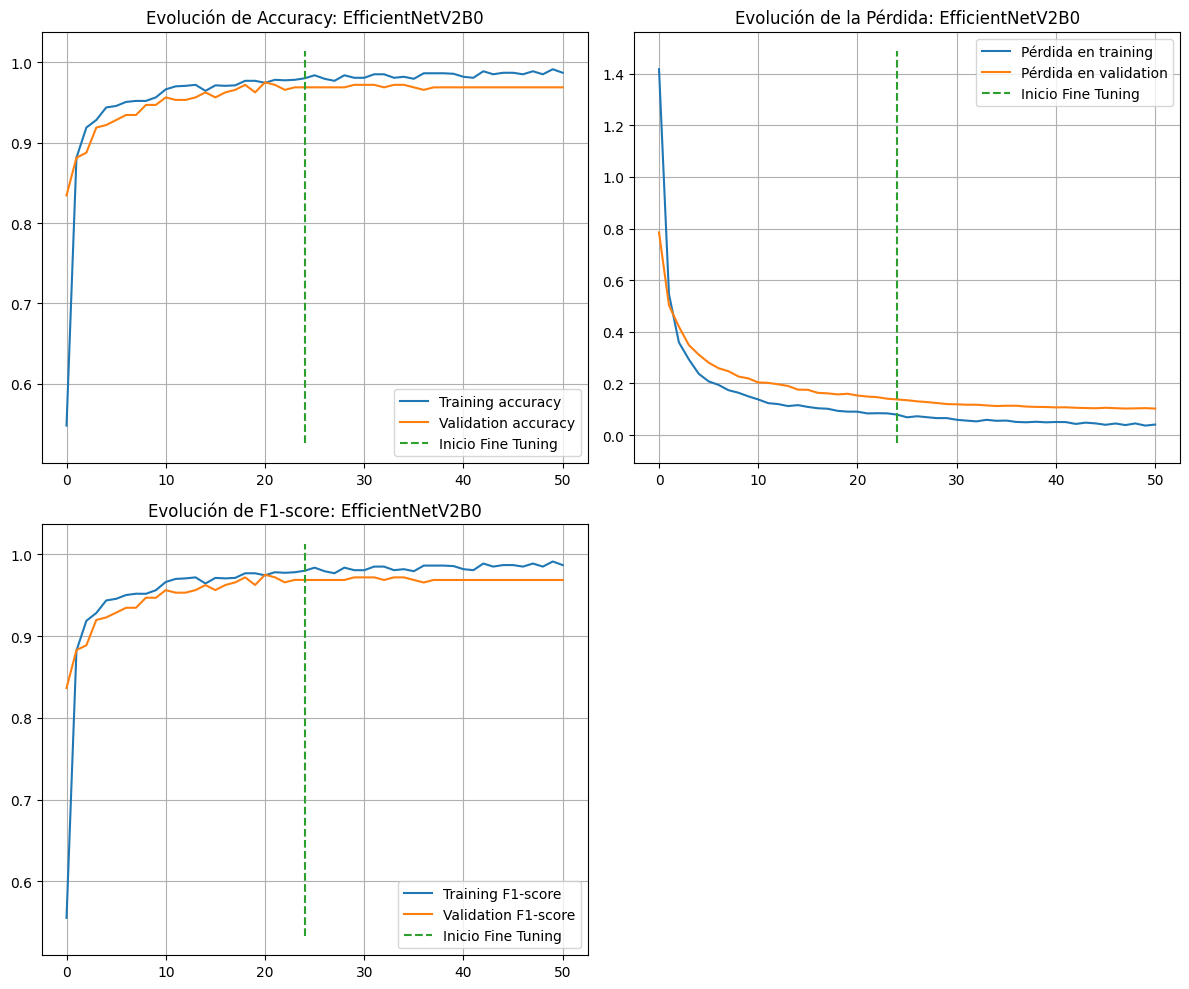

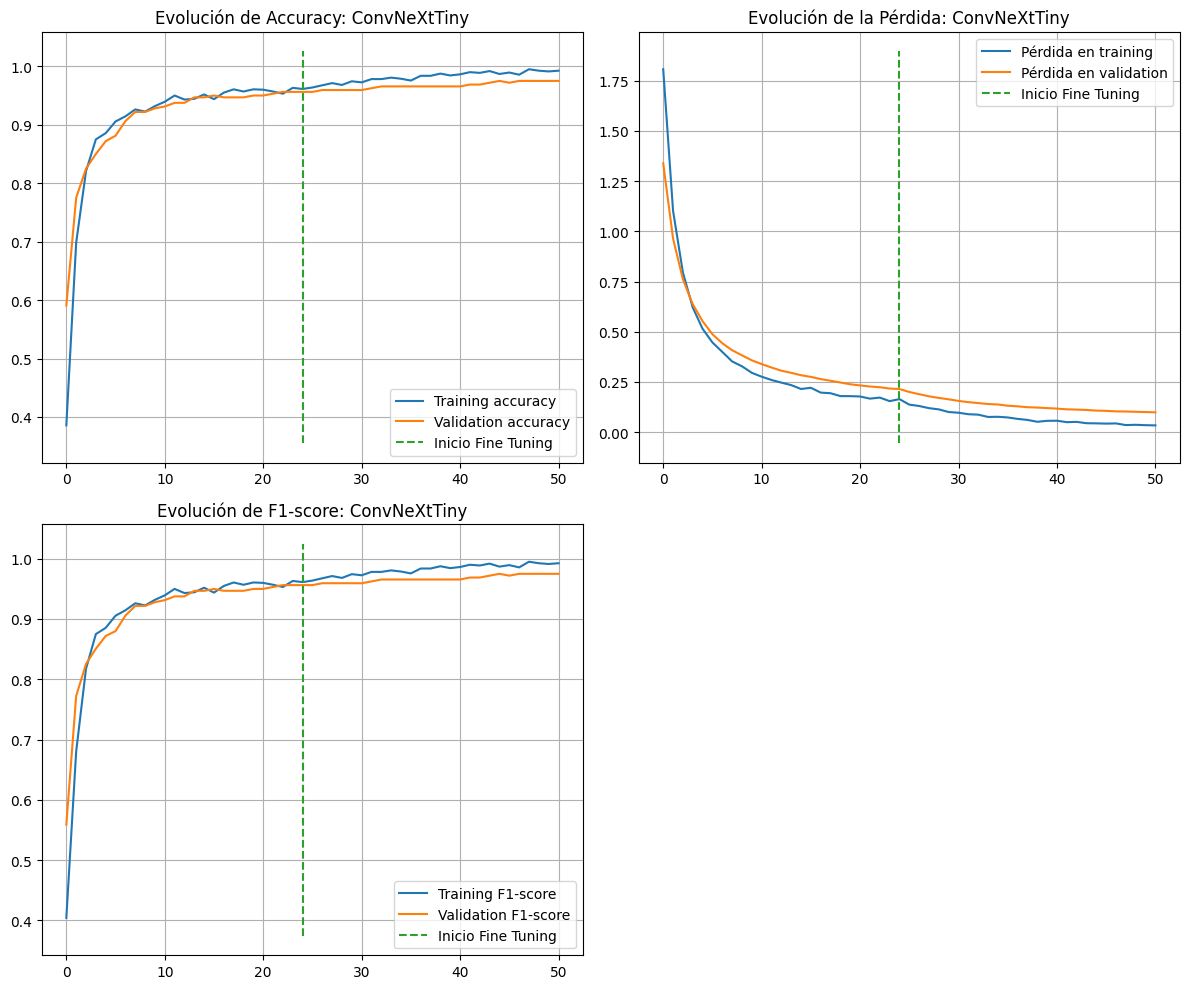

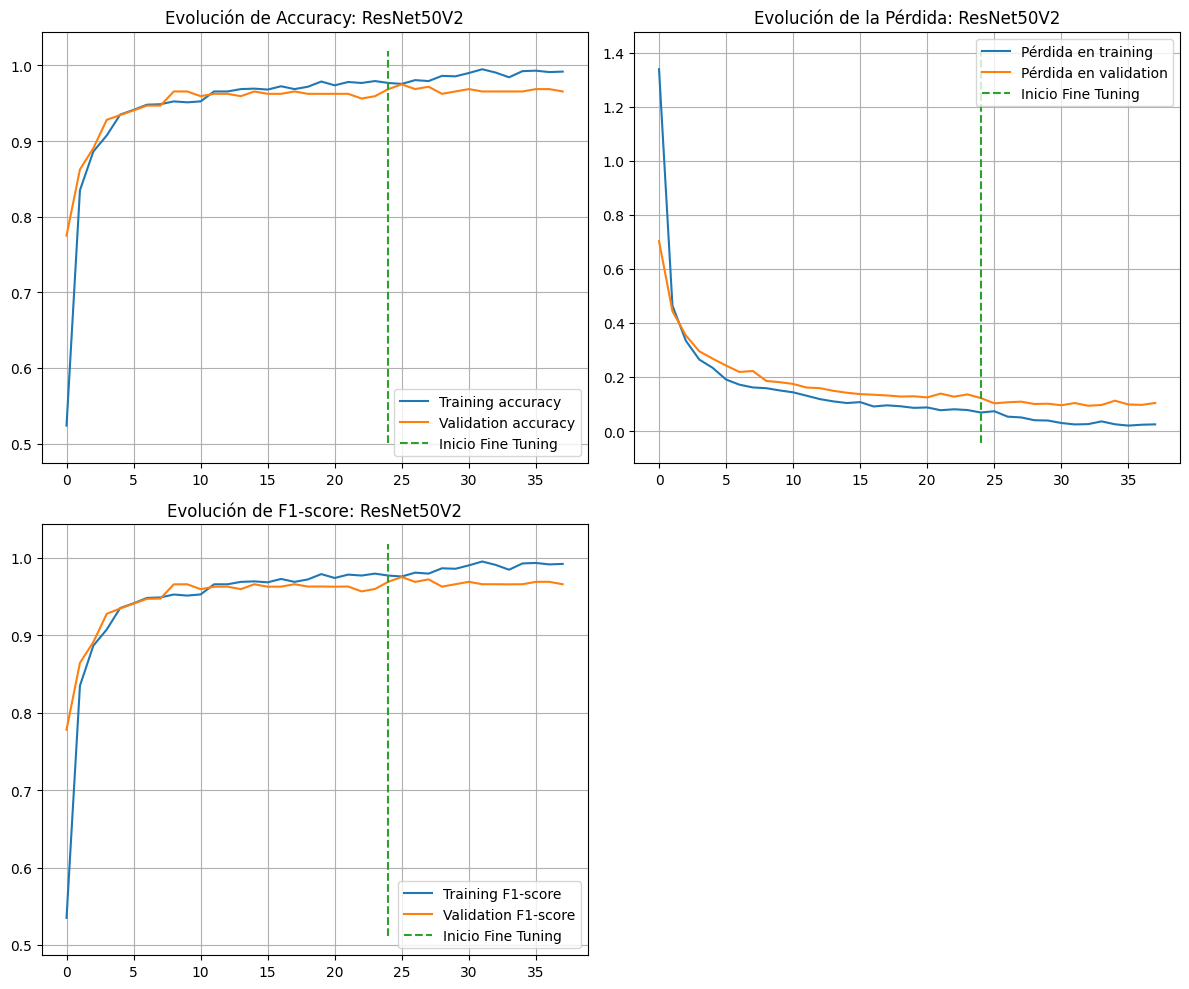

In [37]:
plt_transfer_learning(results_ES,fine_tune_starts_ES)

#### Gráficas SIN Early Stopping

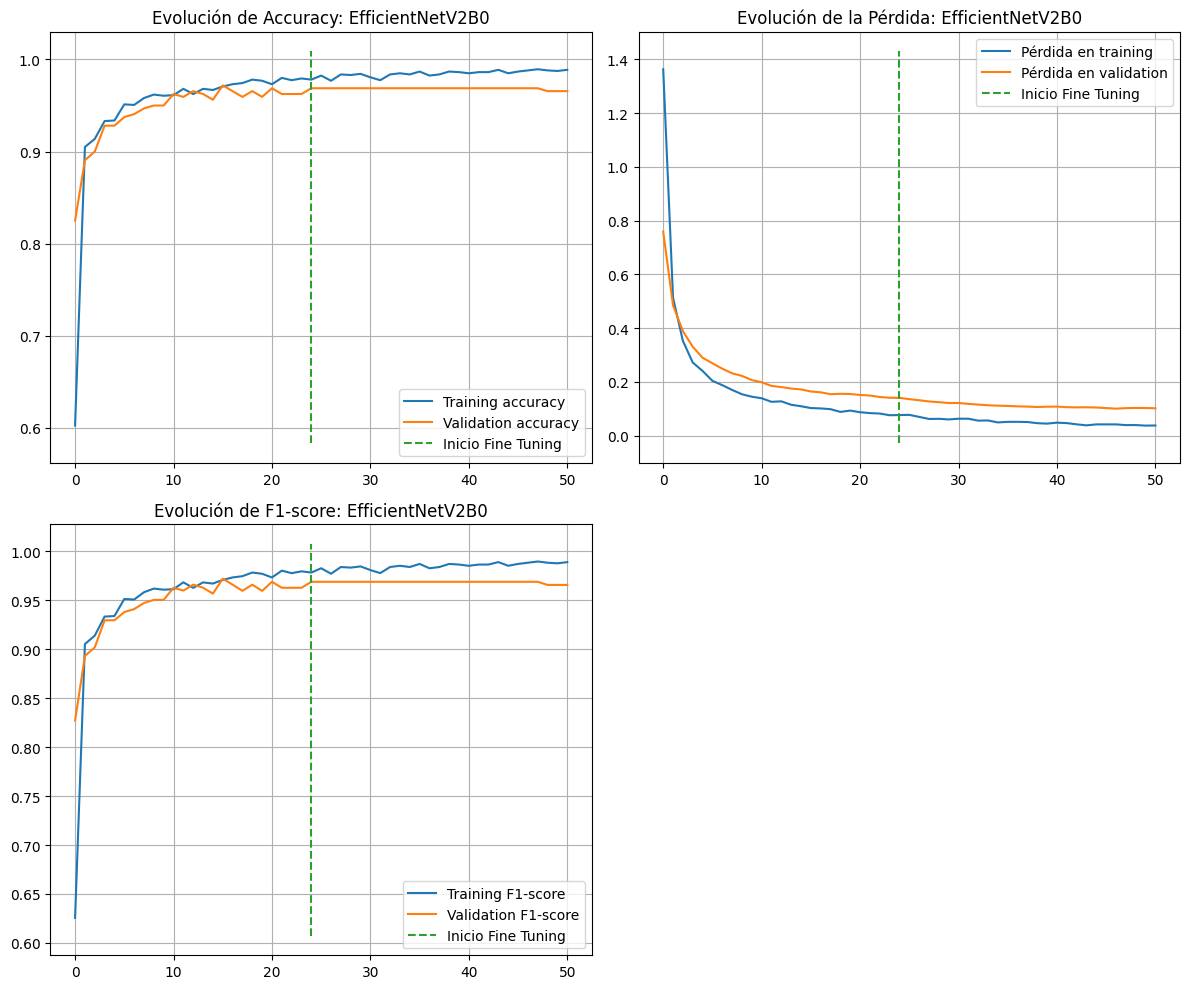

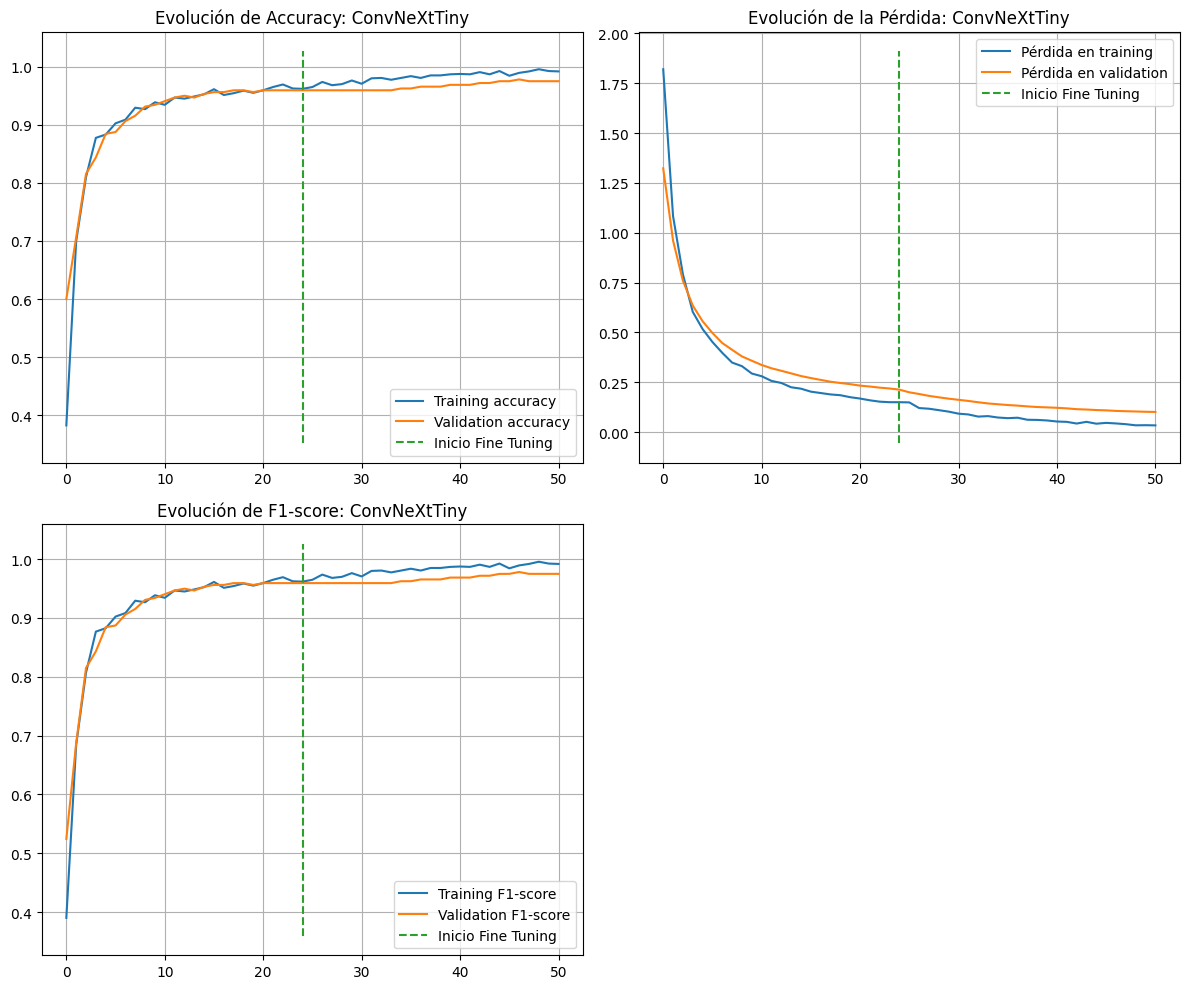

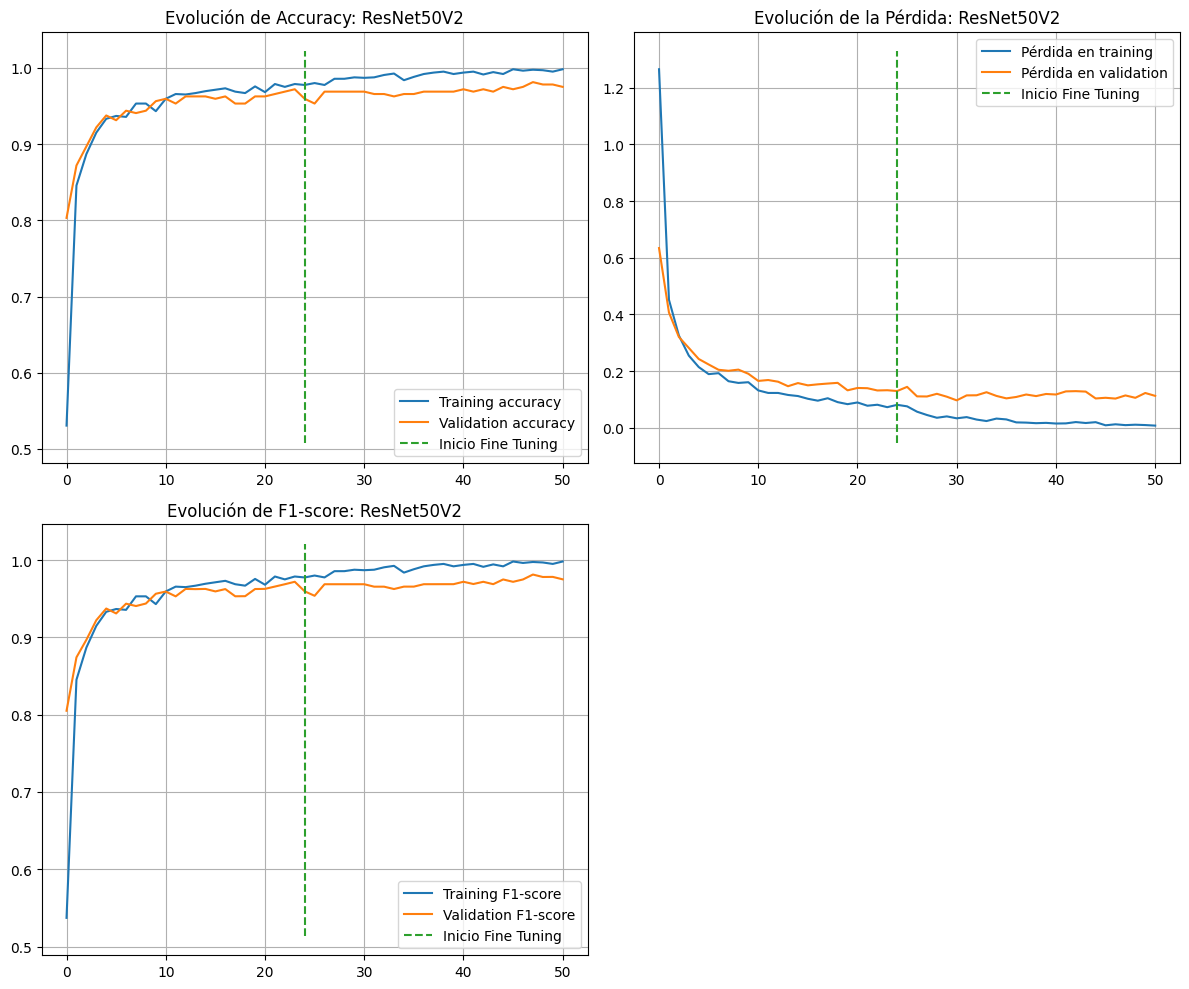

In [38]:
plt_transfer_learning(results,fine_tune_starts)

TODO: Conclusion

## 6. Modelos de Hugging Face (HF)

#### Limpieza de variables y basura para ejecutar en local

In [39]:
# Limpiamos sesiones anteriores para liberar VRAM de la GPU (en nuestros portátiles es necesario)
tf.keras.backend.clear_session()
gc.collect()

USE_REDUCED_BATCH_SIZE = True 

if USE_REDUCED_BATCH_SIZE:
    BATCH_SIZE_VIT = 16
    print(f"Usando Batch Size REDUCIDO: {BATCH_SIZE_VIT}")
else:
    BATCH_SIZE_VIT = 64
    print(f"Usando Batch Size: {BATCH_SIZE_VIT}")

Usando Batch Size REDUCIDO: 16


#### Carga de train y validation

In [40]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_ds, val_ds, test_ds, class_names, full_ds = do_pipeline(data_dir,IMG_HEIGHT,IMG_WIDTH,BATCH_SIZE)
train_ds, val_ds, test_ds = do_performance(train_ds, val_ds, test_ds)

--- Cargando dataset con tamaño: 224x224 y Batch: 64 ---
Found 2348 files belonging to 6 classes.
Clases encontradas: ['GOD_OF_WAR_1', 'HADES', 'HOLLOW_KNIGHT', 'MARIO_GALAXY', 'MINECRAFT', 'UNDERTALE']
Total batches: 37 -> Train: 25, Val: 5, Test: 7


In [41]:
train_ds_vit = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_VIT,
    label_mode='int'
)

val_ds_vit = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_VIT,
    label_mode='int'
)
# Optimización de carga
AUTOTUNE = tf.data.AUTOTUNE
train_ds_vit = train_ds_vit.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_vit = val_ds_vit.cache().prefetch(buffer_size=AUTOTUNE)

Found 2348 files belonging to 6 classes.
Using 1996 files for training.
Found 2348 files belonging to 6 classes.
Using 352 files for validation.


#### Funciones de ViT

In [42]:
class HFVisionWrapper(layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.model_name = model_name
        # TFAutoModel carga la arquitectura correcta (ViT, Swin, DeiT, Beit...) automáticamente
        self.hf_model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.hf_model.trainable = False # Congelamos pesos base
        
    def call(self, inputs):
        outputs = self.hf_model(pixel_values=inputs)
        
        # ESTRATEGIA DE SALIDA:
        # 1. Si el modelo tiene 'pooler_output' (ej. ViT, DeiT), usamos eso (es el token CLS procesado).
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            return outputs.pooler_output
        
        # 2. Si no (ej. Swin), tomamos el 'last_hidden_state' y hacemos un promedio (GlobalAvgPooling).
        # last_hidden_state shape: (Batch, Secuencia, Canales) -> (Batch, Canales)
        else:
            return tf.reduce_mean(outputs.last_hidden_state, axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": self.model_name})
        return config

def build_hf_classifier(model_name, img_height, img_width, num_classes=10, preprocessing='neg_one_to_one'):
    # Importante: Definimos el batch_shape explícito si es posible, o input normal
    inputs = keras.Input(shape=(img_height, img_width, 3))
    
    # 1. Augmentation
    data_augmentation = keras.Sequential(name="data_augmentation")
    data_augmentation.add(layers.RandomFlip("horizontal_and_vertical"))
    data_augmentation.add(layers.RandomRotation(0.2))
    data_augmentation.add(layers.RandomZoom(0.1))
    
    x = data_augmentation(inputs)
    
    # 2. Adaptación
    x = layers.Resizing(224, 224)(x)
    
    if preprocessing == 'neg_one_to_one':
        x = layers.Rescaling(1./127.5, offset=-1)(x)
    elif preprocessing == 'zero_to_one':
        x = layers.Rescaling(1./255)(x)

    # --- CORRECCIÓN CRÍTICA ---
    # 1. Reshape explícito para arreglar dimensiones perdidas por DataAugmentation
    x = layers.Reshape((224, 224, 3))(x)

    # 2. Transposición OBLIGATORIA a Channels First (NCHW)
    # Tanto para Swin como para ViT cargados desde PyTorch.
    x = layers.Permute((3, 1, 2))(x)
    # --------------------------
        
    # 3. Transformer Wrapper
    x = HFVisionWrapper(model_name)(x)
    
    # 4. Head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs, name=f"HF_{model_name.split('/')[-1]}")

In [43]:
# Lista de candidatos HF.
# Estructura: (Nombre en HF, Tipo de preprocesamiento recomendado)
hf_candidates = [
    # ViT
    ('google/vit-base-patch16-224', 'neg_one_to_one'), 
    
    # Microsoft Swin (Jerárquico, suele batir a ViT). Usamos versión Tiny para ir rápido.
    #('microsoft/swin-tiny-patch4-window7-224', 'zero_to_one'), da muchos problemas con el formato de la entrada, me rindo

    # Facebook ConvNeXt (Versión Tiny)
    #('facebook/convnext-tiny-224', 'zero_to_one'), ya lo tenemos en transfer learning

    # Apple MobileViT (Híbrido - CNN + Transformer Ligero)
    ('apple/mobilevit-small', 'zero_to_one'),
    
    # Facebook DeiT (Optimizado para entrenar con menos datos)
    ('facebook/deit-tiny-patch16-224', 'zero_to_one')
]

results_hf = {}
times_hf = {}

print(f"--- Iniciando comparativa de Transformers (Batch: {BATCH_SIZE_VIT}) ---")

for model_name, prep_type in hf_candidates:
    print(f"\n>>> Entrenando: {model_name}")
    
    # Construir
    hf_model = build_hf_classifier(model_name, IMG_HEIGHT, IMG_WIDTH, num_classes=10, preprocessing=prep_type)
    
    # Compilar
    hf_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
    )
    
    # Callbacks (Checkpoint específico para cada uno)
    ckpt_name = f"best_hf_{model_name.split('/')[-1]}.keras"
    callbacks_hf = [
        callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        callbacks.ModelCheckpoint(ckpt_name, monitor='val_accuracy', save_best_only=True, verbose=0)
    ]
    
    # Entrenar
    start_time = time.time()
    hist = hf_model.fit(
        train_ds_vit, # Asegúrate de usar el dataset con el batch size adecuado para ViT
        epochs=8,     # Pocas épocas para probar
        validation_data=val_ds_vit,
        callbacks=callbacks_hf,
        verbose=1
    )
    total_time = time.time() - start_time
    
    # Guardar métricas y limpiar
    results_hf[model_name] = hist
    times_hf[model_name] = total_time
    
    keras.backend.clear_session()

--- Iniciando comparativa de Transformers (Batch: 16) ---

>>> Entrenando: google/vit-base-patch16-224


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use

Epoch 1/8
125/125 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.8592 - f1_score: 0.8602

/usr/local/lib/python3.12/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


125/125 [==============================] - 39s 212ms/step - loss: 0.4684 - accuracy: 0.8592 - f1_score: 0.8602 - val_loss: 0.2019 - val_accuracy: 0.9460 - val_f1_score: 0.9461
Epoch 2/8
125/125 [==============================] - 21s 172ms/step - loss: 0.1774 - accuracy: 0.9409 - f1_score: 0.9409 - val_loss: 0.2049 - val_accuracy: 0.9233 - val_f1_score: 0.9234
Epoch 3/8
125/125 [==============================] - 22s 173ms/step - loss: 0.1322 - accuracy: 0.9544 - f1_score: 0.9544 - val_loss: 0.1765 - val_accuracy: 0.9375 - val_f1_score: 0.9375
Epoch 4/8
125/125 [==============================] - 21s 172ms/step - loss: 0.1065 - accuracy: 0.9639 - f1_score: 0.9639 - val_loss: 0.1990 - val_accuracy: 0.9261 - val_f1_score: 0.9276
Epoch 5/8
125/125 [==============================] - 23s 186ms/step - loss: 0.1090 - accuracy: 0.9634 - f1_score: 0.9634 - val_loss: 0.1474 - val_accuracy: 0.9517 - val_f1_score: 0.9516
Epoch 6/8
125/125 [==============================] - 21s 171ms/step - loss: 0.07

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]


TFMobileViTConvLayer has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU

TFMobileViTConvLayer has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU

TFMobileViTConvLayer has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU

TFMobileViTConvLayer has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU

TFMobileViTConvLayer has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU

TFMobileViTConvLayer has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU

TFMobileViTConvLayer has backpropagation operations that are NOT supported on CPU. If you wis

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFMobileViTModel: ['mobilevit.encoder.layer.3.conv_projection.normalization.num_batches_tracked', 'classifier.weight', 'classifier.bias', 'mobilevit.encoder.layer.3.downsampling_layer.reduce_1x1.normalization.num_batches_tracked', 'mobilevit.encoder.layer.1.layer.1.conv_3x3.normalization.num_batches_tracked', 'mobilevit.encoder.layer.0.layer.0.reduce_1x1.normalization.num_batches_tracked', 'mobilevit.encoder.layer.3.downsampling_layer.expand_1x1.normalization.num_batches_tracked', 'mobilevit.encoder.layer.2.conv_kxk.normalization.num_batches_tracked', 'mobilevit.encoder.layer.3.downsampling_layer.conv_3x3.normalization.num_batches_tracked', 'mobilevit.encoder.layer.3.conv_kxk.normalization.num_batches_tracked', 'mobilevit.encoder.layer.1.layer.1.reduce_1x1.normalization.num_batches_tracked', 'mobilevit.encoder.layer.4.downsampling_layer.expand_1x1.normalization.num_batches_tracked', 'mobilevit.encoder.la

Epoch 1/8
125/125 [==============================] - 35s 147ms/step - loss: 0.4965 - accuracy: 0.8537 - f1_score: 0.8564 - val_loss: 0.3662 - val_accuracy: 0.8750 - val_f1_score: 0.8759
Epoch 2/8
125/125 [==============================] - 10s 79ms/step - loss: 0.1687 - accuracy: 0.9474 - f1_score: 0.9472 - val_loss: 0.3181 - val_accuracy: 0.8778 - val_f1_score: 0.8793
Epoch 3/8
125/125 [==============================] - 10s 79ms/step - loss: 0.1196 - accuracy: 0.9634 - f1_score: 0.9634 - val_loss: 0.1969 - val_accuracy: 0.9403 - val_f1_score: 0.9403
Epoch 4/8
125/125 [==============================] - 10s 79ms/step - loss: 0.1062 - accuracy: 0.9619 - f1_score: 0.9619 - val_loss: 0.1959 - val_accuracy: 0.9432 - val_f1_score: 0.9426
Epoch 5/8
125/125 [==============================] - 9s 74ms/step - loss: 0.0945 - accuracy: 0.9684 - f1_score: 0.9684 - val_loss: 0.2038 - val_accuracy: 0.9432 - val_f1_score: 0.9429
Epoch 6/8
125/125 [==============================] - 9s 75ms/step - loss: 0

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
125/125 [==============================] - 19s 76ms/step - loss: 0.8896 - accuracy: 0.7395 - f1_score: 0.7401 - val_loss: 0.5248 - val_accuracy: 0.8381 - val_f1_score: 0.8381
Epoch 2/8
125/125 [==============================] - 7s 54ms/step - loss: 0.3708 - accuracy: 0.8798 - f1_score: 0.8795 - val_loss: 0.4074 - val_accuracy: 0.8466 - val_f1_score: 0.8438
Epoch 3/8
125/125 [==============================] - 7s 54ms/step - loss: 0.2975 - accuracy: 0.8998 - f1_score: 0.8994 - val_loss: 0.3302 - val_accuracy: 0.8920 - val_f1_score: 0.8904
Epoch 4/8
125/125 [==============================] - 7s 53ms/step - loss: 0.2534 - accuracy: 0.9128 - f1_score: 0.9125 - val_loss: 0.2883 - val_accuracy: 0.9034 - val_f1_score: 0.9030
Epoch 5/8
125/125 [==============================] - 6s 50ms/step - loss: 0.2343 - accuracy: 0.9228 - f1_score: 0.9227 - val_loss: 0.2993 - val_accuracy: 0.8864 - val_f1_score: 0.8850
Epoch 6/8
125/125 [==============================] - 6s 50ms/step - loss: 0.214

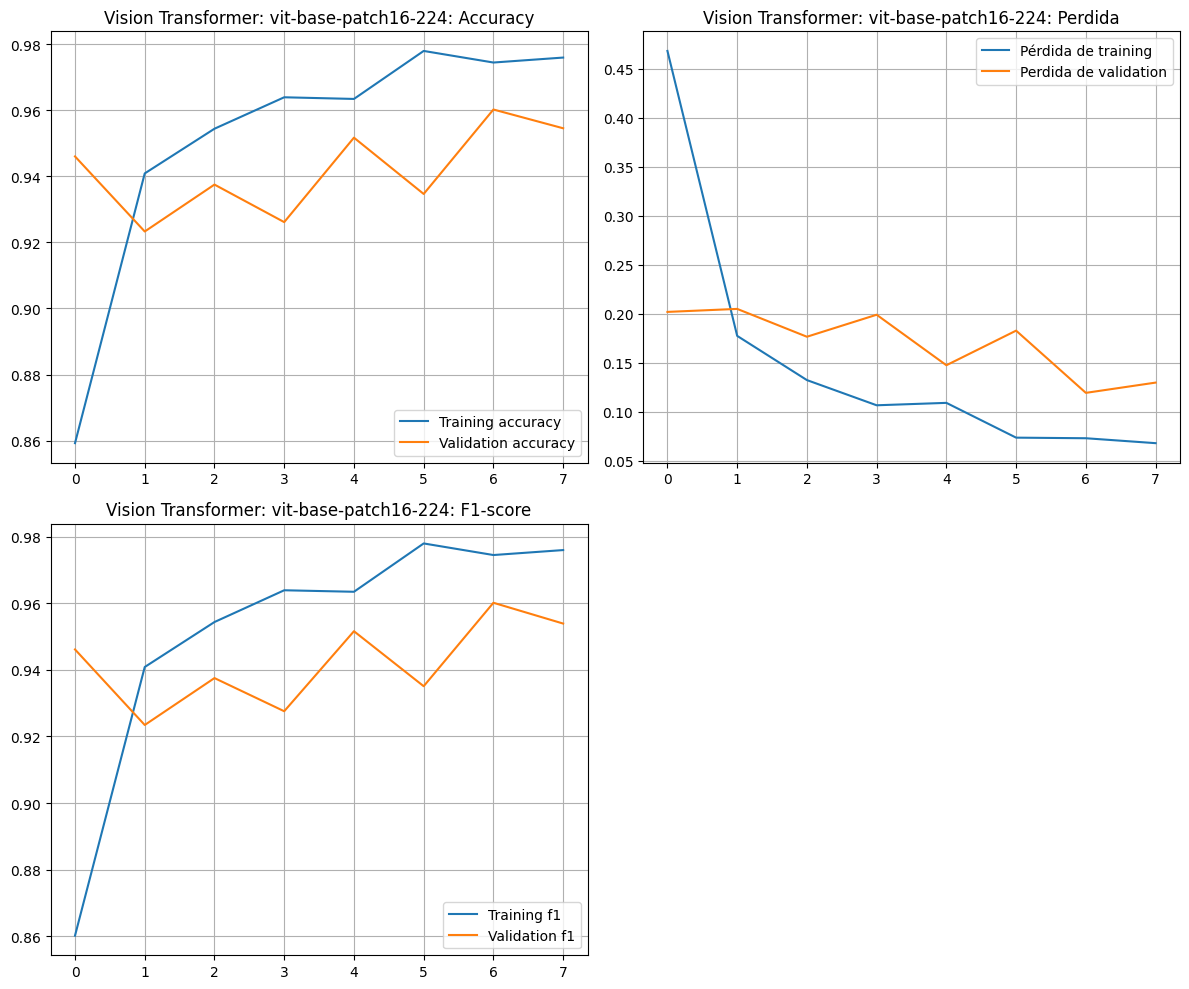

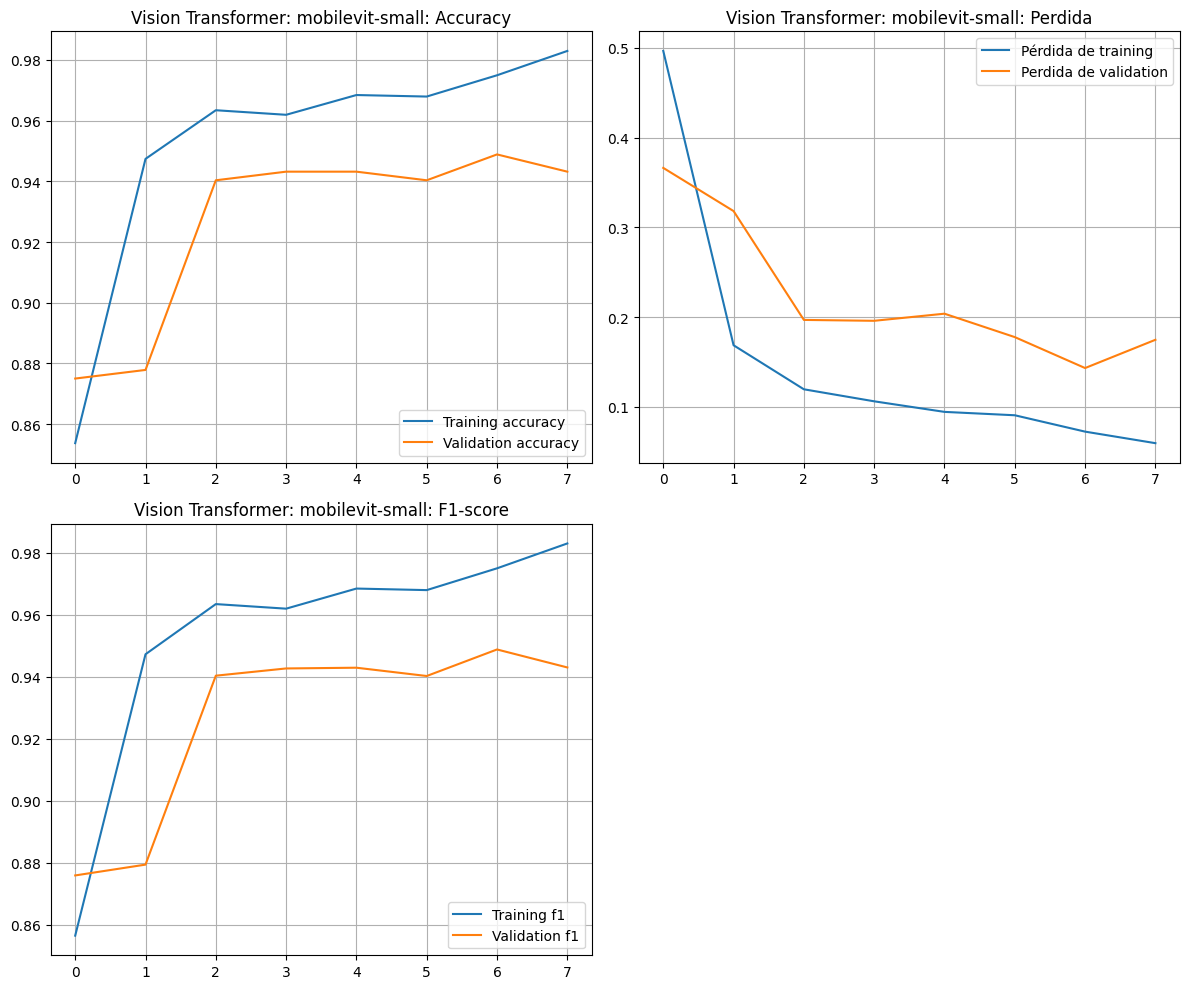

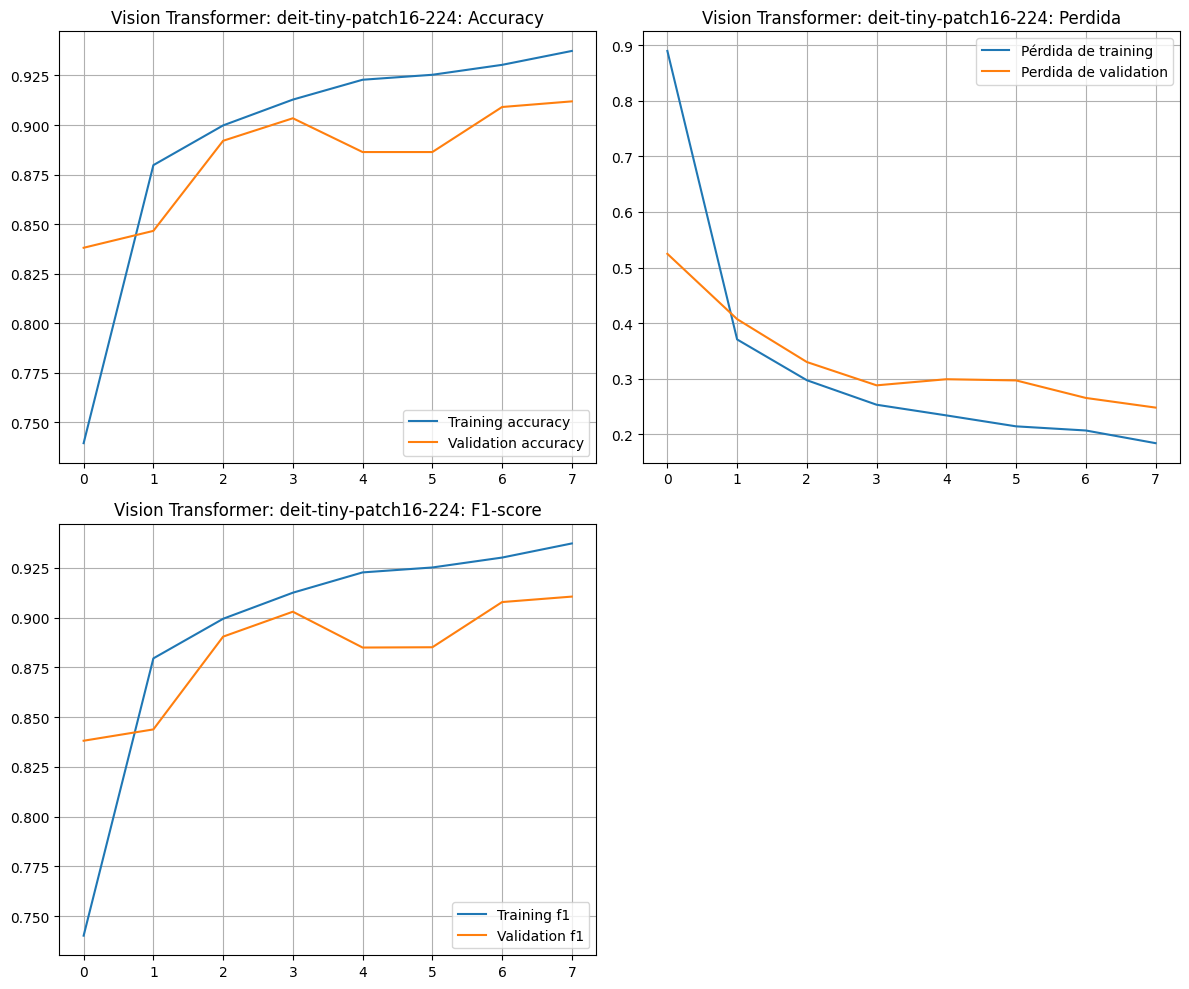

NameError: name 'history_vit' is not defined

In [44]:
# Recorremos el diccionario de resultados generados
for model_full_name, hist in results_hf.items():
    
    # 1. Limpiamos el nombre (ej: de 'google/vit-base...' a 'vit-base...')
    # para que quede limpio en el título de la gráfica.
    clean_name = model_full_name.split('/')[-1]
    
    # 2. Creamos la variable con el string del nombre
    plot_title = f"Vision Transformer: {clean_name}"
    
    # 3. Llamada adaptada a función
    plot_history(hist, plot_title)

# Recuperamos las métricas de la CNN asumiendo que siguen en memoria
cnn_best_val_acc = max(history_cnn.history['val_accuracy'])
cnn_best_val_f1 = max(history_cnn.history['val_f1_score'])
cnn_params = cnn_model.count_params()

# Recuperamos métricas del ViT
vit_best_val_acc = max(history_vit.history['val_accuracy'])
vit_best_val_f1 = max(history_vit.history['val_f1_score'])
vit_params = vit_model.count_params()

# tabla comparativa
print("\n" + "="*75)
print("                         CNN vs ViT")
print("="*75)
print(f"{'Modelo':<25} | {'Parámetros':<12} | {'Val Acc':<10} | {'Val F1':<10} | {'Tiempo(s)':<10}")
print("-" * 75)

# CNN
print(f"{'CNN (Propia)':<25} | {cnn_par:<12,} | {cnn_best_val_acc:.4f}  | {cnn_best_val_f1:.4f}     | {cnn_training_time:.1f}")

# ViT
print(f"{'ViT (HuggingFace)':<25} | {vit_params:<12,} | {vit_best_val_acc:.4f}  | {vit_best_val_f1:.4f}     | {vit_training_time:.1f}")
print("-" * 75)

# Grafica comparativa
plt.figure(figsize=(10, 6))

# Curva CNN
val_acc_cnn = history_cnn.history['val_accuracy']
plt.plot(val_acc_cnn, label=f'CNN Propia (Max: {cnn_best_val_acc:.2%})', linestyle='--', linewidth=2)

# Curva ViT
val_acc_vit = history_vit.history['val_accuracy']
plt.plot(val_acc_vit, label=f'ViT (Max: {vit_best_val_acc:.2%})', linewidth=2)

plt.title('Comparativa de Validación: Convolución vs Transformer')
plt.xlabel('Épocas')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()


TODO: Conclusion

## 7. Evaluación y Análisis Comparativo

In [ ]:
def save_metric(model_input, history_input, name, time_input=0):
    """
    Admite nombres de variables (str) o los objetos directamente.
    """
    # 1. OBTENER EL MODELO
    if isinstance(model_input, str):
        if model_input not in globals(): return None
        model = globals()[model_input]
    else:
        model = model_input

    # 2. OBTENER EL HISTORY
    if isinstance(history_input, str):
        if history_input not in globals(): return None
        history_obj = globals()[history_input]
    else:
        history_obj = history_input

    # 3. OBTENER EL TIEMPO
    if isinstance(time_input, str):
        time_val = globals().get(time_input, 0)
    else:
        time_val = time_input

    # 4. EXTRAER MÉTRICAS
    try:
        # Detectamos si es un objeto History de Keras (tiene atributo .history) o un diccionario puro
        history_dict = history_obj.history if hasattr(history_obj, 'history') else history_obj
        
        # Obtenemos máximos
        val_acc = max(history_dict['val_accuracy'])
        val_f1 = max(history_dict['val_f1_score'])
        params = model.count_params()
        
        return {
            "Modelo": name,
            "Accuracy (Val)": val_acc,
            "F1-score (Val)": val_f1,
            "Nº Parámetros": params,
            "Tiempo (s)": time_val
        }
    except Exception as e:
        print(f"Error al procesar métricas de '{name}': {e}")
        return None

In [ ]:
print("Recopilando métricas...")

best_model_path = 'best_transfer_.keras' 
try:
    best_model = tf.keras.models.load_model(
        best_model_path,
        custom_objects={'SparseF1Score': SparseF1Score} 
    )
    print("Modelo cargado.")
except:
    print(f"Error cargando {best_model_path}.")
    best_model = None

metrics_data = []

metrics_data.append(save_metric('mlp_model', 'history_mlp', 'MLP Baseline', 'mlp_training_time'))
metrics_data.append(save_metric('cnn_model', 'history_cnn', 'CNN Propia', 'cnn_training_time'))
for name, hist in results.items():
    metrics_data.append(save_metric(
        model_input=models[name],     
        history_input=hist,              
        name=f"TL: {name}",              
        time_input=times.get(name, 0) 
    ))
    
metrics_data.append(save_metric('vit_model', 'history_vit', 'Vision Transformer', 'vit_training_time'))

# Limpieza de RAM
heavy_vars = ['mlp_model', 'cnn_model', 'transfer_model', 'base_model', 'vit_model',
              'train_ds', 'val_ds', 'train_ds_vit', 'val_ds_vit', 'test_images', 'test_probs']
for var in heavy_vars:
    if var in globals(): del globals()[var]
tf.keras.backend.clear_session()
gc.collect()


# Filtramos 'allBands' si existe
real_class_names = [c for c in class_names if c != 'allBands']
print(f"Clases válidas para evaluación ({len(real_class_names)}): {real_class_names}")

if best_model:
    print("Generando predicciones...")
    y_true, y_pred, error_samples = [], [], []
    
    # Si test_ds fue borrado por el script anterior de limpieza, lo recargamos:
    if 'test_ds' not in globals():
        test_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir, validation_split=0.15, subset="validation", seed=SEED,
            image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=32, label_mode='int'
        )

    for batch_images, batch_labels in test_ds:
        preds = best_model.predict(batch_images, verbose=0)
        preds_ids = np.argmax(preds, axis=1)
        labels_ids = batch_labels.numpy().astype(int)
        
        valid_mask = labels_ids < 10 
        
        y_true.extend(labels_ids[valid_mask])
        y_pred.extend(preds_ids[valid_mask])
        
        if len(error_samples) < 5:
            batch_errors = np.where((preds_ids != labels_ids) & valid_mask)[0]
            for idx in batch_errors:
                if len(error_samples) >= 5: break
                error_samples.append({
                    'img': batch_images[idx].numpy().astype("uint8"),
                    'true': real_class_names[labels_ids[idx]],
                    'pred': real_class_names[preds_ids[idx]],
                    'conf': np.max(preds[idx])
                })
        del batch_images, batch_labels, preds
        gc.collect()

    print("\nMATRIZ DE CONFUSIÓN")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    # Usamos real_class_names que tiene el tamaño correcto
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=real_class_names, yticklabels=real_class_names)
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.show()
    
    print("\nCLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, target_names=real_class_names))
    
    if error_samples:
        print(f"\nVisualización de errores:")
        plt.figure(figsize=(15, 4))
        for i, sample in enumerate(error_samples):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(sample['img'])
            plt.title(f"R: {sample['true']}\nP: {sample['pred']}\n{sample['conf']:.1%}", 
                      color='red', fontsize=9)
            plt.axis("off")
        plt.show()


df_results = pd.DataFrame([m for m in metrics_data if m is not None])
if not df_results.empty:
    df_results = df_results.sort_values(by="Accuracy (Val)", ascending=False)
    display(df_results)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_results, x='Modelo', y='Accuracy (Val)', palette='viridis')
    plt.title("Comparativa Final")
    plt.ylim(0, 1.05)
    for i, v in enumerate(df_results['Accuracy (Val)']):
        plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
    plt.show()

    df_results = df_results.sort_values(by="F1-score (Val)", ascending=False)
    display(df_results)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_results, x='Modelo', y='F1-score (Val)', palette='viridis')
    plt.title("Comparativa Final")
    plt.ylim(0, 1.05)
    for i, v in enumerate(df_results['F1-score (Val)']):
        plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
    plt.show()


### Análisis Cuantitativo
TODO: Conclusion


### Análisis Cualitativo
TODO: Conclusion

### Comparativa final
TODO: Conclusion